In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import cv2
import glob
import os

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical




images_path = "C:/Users/amolk/Image_caption_dataset/Images/"
captions_path = "C:/Users/amolk/Image_caption_dataset/captions.txt"
glove_path = 'C:/Users/amolk/glove6b'


doc = open(r'C:\Users\amolk\Image_caption_dataset\captions.txt','r').read()

dataset = list()
descriptions = dict()
data_train_test = dict()
header = True
for line in doc.split("\n"):
    if header:
        header = False
        continue
    tokens = line.split()
    if len(line) > 2:
        # image_id_train_data = tokens[0]
        image_id = tokens[0].split('.')[0]
        image_id_train_data = image_id + '.jpg'
        dataset.append(image_id)
        image_desc = ' '.join(tokens[1:])
        if image_id not in descriptions:
            descriptions[image_id] = list()
            data_train_test[image_id_train_data] = list()
        descriptions[image_id].append(image_desc)
        data_train_test[image_id_train_data].append(image_desc)


table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] = ' '.join(desc)


# img = cv2.imread(r'C:\Users\amolk\Image_caption_dataset\Images\44856031_0d82c2c7d1.jpg')
# cv2.imshow('Image', img)
# cv2.waitKey()
# print(descriptions['44856031_0d82c2c7d1'])


# Splits the dataset into training, test sets
def train_val_split(caption_data, test_size=0.2, shuffle=True):
    # Getting the list of all image names
    all_images = list(caption_data.keys())

    # Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    train_keys, test_keys = train_test_split(all_images, test_size=test_size)
    #     validation_keys, test_keys = train_test_split(validation_keys, test_size=test_size, random_state=42)

    training_data = {img_name: caption_data[img_name] for img_name in train_keys}
    #     validation_data = {img_name: caption_data[img_name] for img_name in validation_keys}
    test_data = {img_name: caption_data[img_name] for img_name in test_keys}

    # Return the splits
    return training_data, test_data




vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(d.split()) for d in descriptions[key]]
# print('original vocab size: %d' % len(vocabulary))

lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key+ ' '+ desc)
new_descriptions = "\n".join(lines)




train_data, test_data = train_val_split(data_train_test)
train = set(train_data)
print(f"----> Number of training samples: {len(train_data)}")
print(f"----> Number of test samples: {len(test_data)}")


img = glob.glob(images_path + '*.jpg')
# print("img", img)
train_img = []
for i in img:
    filename = os.path.basename(i)
    # print("filename", filename)
    # print("i", i)
    # if filename in train_data:
    if i[len(images_path):] in train_data:
        train_img.append(i)

test_img = []
for i in img:
    filename = os.path.basename(i)
    # if filename in test_data:
    if i[len(images_path):] in train_data:
        test_img.append(i)


train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id + '.jpg' in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)
print(len(train_descriptions))


all_train_captions = []
for key, desc in train_descriptions.items():
    for cap in desc:
        all_train_captions.append(cap)

print(len(all_train_captions))


word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:

    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))


ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1


all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)
print(max_length)


embeddings_index = {}
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs



embeddings_dim = 200
embeddings_matrix = np.zeros((vocab_size, embeddings_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector


model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)



def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x


def encode(image):
    image = preprocess(image)
    fea_vec = model_new.predict(image)
    print('fea_vec', fea_vec)
    print('fea_vec_shape', fea_vec.shape)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
# print("train_img", train_img)
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)

train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)



inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embeddings_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)


decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()


model.layers[2].set_weights([embeddings_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam')



def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0



epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size
print("train_features", train_features)
generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)



----> Number of training samples: 6472
----> Number of test samples: 1619
6472
32360
Vocabulary = 1740
37


1/1 [==============================] - 1s 1s/step
fea_vec [[0.12277617 0.3329496  0.752717   ... 0.21939683 0.30216393 0.40283135]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.73668385 0.5911323  0.181942   ... 0.16030279 0.3414467  0.90831685]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 97ms/step
fea_vec [[0.48603132 0.2921833  0.31436872 ... 0.9825474  0.28108078 0.22330052]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.2159535  0.15582038 0.29477057 ... 0.40565002 0.16532059 0.37416768]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.1723103  0.49808383 0.21576996 ... 0.09676256 1.2298474  0.54214144]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.2311844  0.12729608 0.396201   ... 0.05

1/1 [==============================] - 0s 78ms/step
fea_vec [[0.43723124 0.18360078 0.17955297 ... 0.11252387 0.38832858 1.0250269 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.21934503 0.07387668 0.10290408 ... 0.32005584 0.18107021 0.00172108]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.3541234  0.4862221  0.11005701 ... 0.19530316 0.86071414 0.17192337]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.8178241  0.07384811 0.2558667  ... 0.9097932  0.7949424  0.6103411 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.47237778 0.35360783 0.41146195 ... 0.8674499  0.33758882 0.38268793]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 100ms/step
fea_vec [[0.74665076 0.37384275 1.265582   ... 0.5047983  1.3712116  0.7805109 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step

1/1 [==============================] - 0s 92ms/step
fea_vec [[0.3260059  0.20189592 0.08621555 ... 0.5028459  0.5972036  0.34255767]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 81ms/step
fea_vec [[0.16554618 0.458302   0.90561354 ... 0.8691481  0.03642851 0.04183049]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.3863908  0.20061505 0.46903583 ... 0.610263   0.06814338 0.04703216]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.2073472  0.14990976 0.261218   ... 0.343571   0.7601382  0.03371276]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.57509756 0.00123471 0.34289306 ... 0.5349375  1.0945626  0.14032304]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step
fea_vec [[0.28592908 0.56035906 0.8369642  ... 0.08270422 0.7494863  0.23110422]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 153ms/step
fea_vec [[0.42846027 0.00684288 0.21254545 ... 0.5214237  0.6777296  1.2260463 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 245ms/step
fea_vec [[0.637907   0.73688054 0.82079494 ... 0.89079267 0.50006425 0.61312115]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 168ms/step
fea_vec [[0.48500013 1.0080543  0.403495   ... 0.908633   1.0248647  0.06296612]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 163ms/step
fea_vec [[0.36192784 0.45781696 0.19913478 ... 0.33372745 0.19789274 0.23877165]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 121ms/step
fea_vec [[0.03998185 0.02396458 0.47675765 ... 0.5303756  0.640442   0.18398151]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 156ms/step
fea_vec [[0.23745151 0.31367326 0.1124863  ... 0.79203427 0.43417746 0.6023713 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 302m

1/1 [==============================] - 0s 109ms/step
fea_vec [[0.4065065  0.08155502 0.05824193 ... 1.5589241  0.00619156 0.21672198]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 106ms/step
fea_vec [[0.19669059 0.7088194  0.8095838  ... 0.28404287 0.38748544 1.2336912 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 116ms/step
fea_vec [[0.7404231  0.71062756 0.8882278  ... 0.08063249 0.6991113  0.12913999]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 127ms/step
fea_vec [[0.0997458  0.23803881 0.15646927 ... 0.8329654  0.3692531  0.24210805]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 124ms/step
fea_vec [[0.56136256 0.34251115 0.48620492 ... 0.32821298 0.19048618 0.08398792]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 104ms/step
fea_vec [[0.44105005 0.15668719 0.88378334 ... 0.08368395 0.39089167 0.24553688]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 114m

1/1 [==============================] - 0s 112ms/step
fea_vec [[0.9918774  0.33349898 0.3799113  ... 0.55734825 1.166304   0.32481384]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 122ms/step
fea_vec [[0.09258249 0.23955448 0.54386044 ... 0.41222796 0.07267015 1.1415797 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 129ms/step
fea_vec [[0.15094247 0.12666857 0.10481805 ... 1.209902   0.3801086  1.1245193 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 113ms/step
fea_vec [[0.25767702 0.19258162 0.51579916 ... 0.0154381  0.6026164  0.2097438 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 243ms/step
fea_vec [[0.2859866  0.31936288 0.39154536 ... 0.02901164 0.49328852 0.61248934]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 125ms/step
fea_vec [[0.30293635 0.25747073 0.40234253 ... 0.507783   0.5558753  0.07451506]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 108m

1/1 [==============================] - 0s 100ms/step
fea_vec [[0.14786716 0.49635124 0.37455478 ... 1.828561   1.1689873  0.10745728]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 155ms/step
fea_vec [[0.64873266 0.96405435 0.6333436  ... 1.0295073  1.0435239  0.962311  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 210ms/step
fea_vec [[0.15003516 0.2890939  0.39492118 ... 0.36176813 0.0700378  0.20900255]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 109ms/step
fea_vec [[0.09125246 0.41125596 0.3210654  ... 0.30454156 0.77872443 0.49203396]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 328ms/step
fea_vec [[0.2724338  0.61361575 0.12008194 ... 0.41498783 0.7879032  0.73442304]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 193ms/step
fea_vec [[0.4291571  0.10335901 0.6152922  ... 0.37249115 1.7106323  0.8469631 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 152m

1/1 [==============================] - 0s 94ms/step
fea_vec [[0.15728384 0.08731862 0.16710168 ... 0.02023377 0.00704614 0.05386341]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 97ms/step
fea_vec [[0.0904365  0.34930763 0.0265652  ... 0.14934602 0.8512169  0.26029223]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 103ms/step
fea_vec [[0.20952015 0.2544744  0.09966868 ... 0.00271205 0.83809364 0.7337735 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 96ms/step
fea_vec [[0.4548357  0.15196542 0.14708284 ... 0.21370685 0.27089247 0.40308055]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.22181234 0.02489851 0.38677606 ... 0.15285562 0.47951248 0.22015694]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.07986293 0.00279489 0.13426489 ... 0.29757926 0.01957292 0.31224528]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step

1/1 [==============================] - 0s 91ms/step
fea_vec [[0.18506396 0.23409583 0.6419331  ... 0.13281076 0.5908026  0.5418494 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.48835984 1.4631652  0.2088963  ... 0.1546985  0.7312994  1.4975728 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step
fea_vec [[0.46296605 0.01477688 0.10653588 ... 0.2441582  1.2355082  0.19462481]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.06018067 0.30348054 0.11289202 ... 0.94436145 0.04668057 0.74974084]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.10430621 0.03212007 0.22764832 ... 0.44502568 0.30378988 0.8912113 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[1.100724   0.21561629 0.76287913 ... 0.19344513 0.4882273  0.17250907]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 128ms/step
fea_vec [[0.7304759  0.23029396 0.61076057 ... 0.05455519 0.33384597 0.6125319 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 151ms/step
fea_vec [[0.43497467 1.2419019  0.02387526 ... 0.20838055 0.12175255 1.1405464 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.08988976 0.00771857 0.146523   ... 0.6213522  0.8066     0.04443671]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 96ms/step
fea_vec [[0.26126415 0.5410681  0.09044861 ... 0.1647819  0.51417905 0.28933293]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 198ms/step
fea_vec [[0.11156891 0.56486654 0.35930687 ... 0.49042207 0.5619903  1.0054419 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.20575315 0.61631835 0.30679154 ... 0.79857385 0.95276326 0.6688099 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 115ms/s

1/1 [==============================] - 0s 88ms/step
fea_vec [[0.17803277 0.14380698 0.18646115 ... 0.16478439 0.1464532  0.52233183]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 81ms/step
fea_vec [[0.22751212 0.42338738 0.41629368 ... 0.01002013 0.06040366 0.21873237]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.24166715 0.12119782 0.0432268  ... 0.27994865 0.07502927 0.07396732]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.20734847 0.29690087 0.6427233  ... 1.0815066  0.16123646 0.25424483]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.65201485 0.48621246 0.22657052 ... 0.6339286  0.99892575 0.06608933]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 135ms/step
fea_vec [[0.14282867 0.19133955 0.03399696 ... 0.11671152 0.07123661 0.13557637]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step

1/1 [==============================] - 0s 145ms/step
fea_vec [[0.07447174 0.21421647 0.2099652  ... 0.03342361 1.1445556  0.31984666]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 99ms/step
fea_vec [[0.19539234 0.27117437 0.48924112 ... 0.12315843 0.207074   0.38758415]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 108ms/step
fea_vec [[0.07560169 0.23720056 0.08560877 ... 0.         0.34654045 0.18117733]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 156ms/step
fea_vec [[0.08031299 0.09240699 0.05209703 ... 0.14365716 0.06960129 0.5233642 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 164ms/step
fea_vec [[0.24945167 0.421495   0.3034054  ... 0.10776705 0.21052954 0.200717  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.27734166 0.7635164  0.30175683 ... 0.24553865 1.0730484  0.66077006]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/s

1/1 [==============================] - 0s 92ms/step
fea_vec [[0.46408826 0.6281649  0.8792193  ... 0.61442053 0.42780071 0.3063978 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.1710896  0.2830558  0.23623058 ... 0.3164728  0.18580353 0.08058795]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step
fea_vec [[1.2656261  0.6034039  0.99194133 ... 0.01204056 0.5009619  0.3635461 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 81ms/step
fea_vec [[0.12051401 0.33813527 0.1698385  ... 0.01084067 0.21576932 0.11320266]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.43395996 0.61922586 0.59051377 ... 0.14049283 0.281038   0.14761019]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.08937252 0.18163444 0.07639486 ... 0.5776698  0.3958421  0.09842662]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 121ms/step
fea_vec [[0.63714737 0.1779707  0.31238607 ... 1.2282243  0.14704758 0.32151413]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 123ms/step
fea_vec [[0.43545905 0.16651472 0.5191246  ... 0.17417632 0.24021803 0.3008938 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[0.36766368 0.05022984 0.05511802 ... 0.15642543 0.5685469  0.04228541]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 103ms/step
fea_vec [[0.08519821 0.11663387 0.29350996 ... 1.0475457  0.83548945 0.831877  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.803707   0.40433106 0.09943335 ... 1.0321211  0.20719554 0.89647686]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.2720624  0.93130445 0.86415255 ... 0.5276966  0.84080994 0.        ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/s

1/1 [==============================] - 0s 94ms/step
fea_vec [[0.1874672  0.29748347 0.59680873 ... 0.30454758 0.47453764 0.01441374]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.13614827 0.13205983 0.38553593 ... 0.31083125 0.02891242 0.37554857]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 101ms/step
fea_vec [[0.25203854 0.18328355 0.09867976 ... 0.3410842  0.6159613  0.35927773]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.09990411 0.49358714 0.47267634 ... 0.0651098  0.11801618 0.02787204]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.5152895  0.30574888 0.10948066 ... 0.12660363 0.48389092 1.1882772 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 76ms/step
fea_vec [[0.814069   0.52117306 0.21091266 ... 0.18089706 0.33767343 0.21227305]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step

1/1 [==============================] - 0s 79ms/step
fea_vec [[0.19697893 0.02752417 0.21660738 ... 0.02270597 0.46819985 0.32498905]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 118ms/step
fea_vec [[0.17973259 0.2817133  0.27434313 ... 0.3833852  0.18776976 0.2639907 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[0.27599415 0.35783702 0.8131834  ... 0.19799921 0.75810766 0.12880813]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[2.1097155  0.24327536 0.40551147 ... 0.4369627  0.16822894 0.739881  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.25784767 0.5262074  0.09000815 ... 1.2141017  0.20301804 0.09269147]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 125ms/step
fea_vec [[0.05642425 0.11716747 0.9944817  ... 1.2247645  0.568839   0.44874606]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 125ms/s

1/1 [==============================] - 0s 99ms/step
fea_vec [[0.3118226  0.24465479 0.5552053  ... 0.02576594 0.623272   0.5447157 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.17338035 0.14126174 0.1818872  ... 0.6233872  0.1217     1.0513495 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.28233746 0.22519077 0.04335984 ... 0.18404633 0.18295833 0.7774913 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 73ms/step
fea_vec [[0.428715   0.35894483 0.15496297 ... 0.3639332  1.664339   0.56243426]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.44011107 0.0918961  0.10152095 ... 0.19208771 0.35549164 0.35623926]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.10604678 0.19114065 0.14449333 ... 0.7247517  0.53767383 0.5636389 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.5334267  0.13569456 0.5896196  ... 0.68151677 0.6856768  1.0984267 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.03048756 0.24583271 0.05624113 ... 0.07421534 0.05260886 0.36401403]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.09052246 0.16676247 0.1108532  ... 0.53167003 1.0534372  0.88302916]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.21193427 0.31273168 0.06368114 ... 0.5586384  0.40171474 0.3704228 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[0.0449283  0.5774636  0.51614493 ... 1.1919475  0.42732    1.1019008 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 69ms/step
fea_vec [[0.29692116 0.1965452  0.8259928  ... 0.47656664 0.11625419 0.36041293]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step

1/1 [==============================] - 0s 76ms/step
fea_vec [[0.39578807 0.7871945  0.10143429 ... 0.37060922 0.1080841  0.4751163 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.03534887 0.01414655 0.01468405 ... 0.08159929 0.1404159  0.33098322]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.09616119 0.19576427 0.5114809  ... 0.03551946 0.05943144 0.30392006]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.1890917  0.12397271 0.6847925  ... 0.3607415  1.0708095  0.15236756]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.25822148 0.3218135  0.4291907  ... 0.5727253  0.05224163 0.02734907]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.25370702 0.08952336 0.27272594 ... 0.12846558 0.51406676 0.8775244 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 73ms/step
fea_vec [[1.2551146  0.0297437  0.56033033 ... 0.02807839 0.34401268 0.64947265]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.4516558  0.13102067 0.04380015 ... 0.17665736 1.3436987  1.4744269 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step
fea_vec [[0.02860708 0.647085   0.13060687 ... 1.2049122  0.08966526 1.3880653 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 71ms/step
fea_vec [[0.08683512 0.03475738 0.0876935  ... 0.02285798 0.09883165 0.7545035 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.46572408 0.9597438  0.45489192 ... 0.41210067 0.26461172 0.07904612]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.19358674 0.34627748 0.2820632  ... 0.694613   0.39823875 0.03983528]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 125ms/step
fea_vec [[0.06271186 0.2946974  0.0147055  ... 0.29133987 0.49730167 0.6876508 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.55015683 0.4398277  0.43698597 ... 0.674037   1.3574109  0.55935156]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 76ms/step
fea_vec [[1.3925444  0.35202432 0.99041635 ... 0.44570774 0.8036942  0.0800951 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 75ms/step
fea_vec [[0.63887346 0.59405917 0.14989896 ... 1.573702   0.70341396 1.0379483 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 85ms/step
fea_vec [[0.7596637  0.2115075  0.33622766 ... 0.07816521 0.5090625  0.3167679 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.02148166 0.30425364 0.05490094 ... 0.3254227  0.20722467 0.580639  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step

1/1 [==============================] - 0s 88ms/step
fea_vec [[0.06307036 0.10295954 0.05949616 ... 0.14473839 0.13757324 0.80505323]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.10484954 0.32299617 0.33519417 ... 0.09774666 1.0277332  0.72750723]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.21076387 0.21704611 0.22709635 ... 0.27029982 0.59282255 0.03280276]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.08855291 0.27773067 0.07633585 ... 0.08221684 0.12230931 0.3298768 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.23843956 0.08801763 0.12990731 ... 0.25277478 0.2721469  0.00949061]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.5406398  0.2086381  0.46443284 ... 0.01224658 0.5651691  1.6525055 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 83ms/step
fea_vec [[0.29436827 0.12303378 0.16030815 ... 0.3001079  0.8383852  0.68392295]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 69ms/step
fea_vec [[0.51941186 0.5609849  0.3866194  ... 0.44291577 0.747123   0.0800406 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.04245326 0.0534209  0.48678267 ... 0.83637464 0.13334613 0.359929  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 71ms/step
fea_vec [[0.3191908  0.22453497 0.8514788  ... 0.27515572 0.85991627 0.17870432]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.23067546 0.74978817 0.31072468 ... 0.10949343 0.63993895 0.59555936]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.3082741  0.40996444 0.4701875  ... 0.10708693 0.08720006 0.2583768 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 95ms/step
fea_vec [[0.2065945  0.7336657  0.5407146  ... 0.44004712 0.42672378 0.1994318 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.5123902  0.23349914 0.19769348 ... 0.28549212 0.6023575  0.80670947]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.21671197 0.43298298 0.11171005 ... 0.34181163 0.5927767  0.3647036 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 71ms/step
fea_vec [[0.23385292 0.7603016  0.11281992 ... 0.5200856  0.3206479  0.60070777]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.08635238 0.06758501 0.21576087 ... 0.4572335  0.8057694  0.29275596]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.49988735 0.05311805 0.27881536 ... 0.         0.07842077 0.40305093]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.13176325 0.22205731 0.37680408 ... 0.15623912 0.21434808 0.29962865]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[1.5203431  0.19320834 1.4022033  ... 0.41605222 0.22620155 0.02621916]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.3749386  0.74784195 0.48753372 ... 0.48452502 0.21998918 0.22998405]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.12889183 0.30036625 0.04675936 ... 0.00169872 0.45551798 0.00924969]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.66735244 0.35815898 0.4884716  ... 0.09287371 1.1490811  0.3659908 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.61645794 0.06681849 0.6726548  ... 0.67219996 0.47708604 0.1723905 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 93ms/step
fea_vec [[0.6810975  0.34575433 0.7852418  ... 0.05632721 0.17113116 0.20524669]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 85ms/step
fea_vec [[0.07706371 0.26339445 0.4445014  ... 0.7943623  0.6328875  0.5010545 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.23230673 0.37125012 0.45414606 ... 0.01813536 0.30526632 0.17502397]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.04605995 0.25080353 0.07365106 ... 0.35268295 0.53947604 0.33026022]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.12889324 0.04882599 0.09569713 ... 0.5414623  0.65091366 0.55337906]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 71ms/step
fea_vec [[0.2992712  0.25689048 0.29369655 ... 1.044179   0.330804   1.2690636 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.22454992 0.10456258 0.25574607 ... 0.25235146 1.0036784  0.49378794]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.08726132 0.61605465 0.39908457 ... 0.4711073  0.5727412  0.05379023]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.48278415 0.13388908 0.4330972  ... 0.25095516 0.71008563 0.41719395]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.19910678 0.6251239  0.18774238 ... 0.11867189 0.31928158 0.15581112]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.21209586 0.27909645 0.24940199 ... 0.19390899 0.50316817 1.2527484 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.4763913  0.36398998 1.1375725  ... 0.11235623 0.29386717 0.05545203]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.52709925 0.19266179 0.07342872 ... 1.0888382  0.00185013 0.27289265]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.21483088 0.29454386 0.27179113 ... 0.45294058 1.0292059  1.312542  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.19608134 0.33356354 0.17840919 ... 0.5837429  0.22832438 0.5802514 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.2744466  0.2035471  0.09768303 ... 0.15787506 0.3768128  0.29799414]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 71ms/step
fea_vec [[0.45134005 0.95808244 0.5359974  ... 0.83125025 0.64076734 0.803812  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step
fea_vec [[0.20086767 0.2286646  0.39639136 ... 0.0353037  0.54772663 0.11766044]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 89ms/step
fea_vec [[0.0798416  0.21746758 0.87003964 ... 0.07058655 0.6667495  0.29671037]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 71ms/step
fea_vec [[0.21901526 0.05633151 0.17476983 ... 0.15029672 0.6530762  0.48341858]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.03068834 0.08167852 0.45674485 ... 0.31227976 0.45438197 0.16635907]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.04545973 0.10579006 0.15800077 ... 0.0272367  0.6190174  0.43104032]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.22704187 0.01415378 0.10475516 ... 0.07288632 0.         0.05179158]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.32578868 0.1832511  0.2337535  ... 0.19264847 0.15320614 0.06615874]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.12756428 0.13757391 0.18347698 ... 0.11206504 0.3531255  0.08048681]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.5240001  0.14173329 0.07545961 ... 0.25437865 0.09849244 1.0275283 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.4533721  0.26635978 0.75756943 ... 0.6433936  0.7979457  0.28616393]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.08719361 0.38813365 0.34200227 ... 0.20633022 0.6114392  0.972745  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.25759184 0.51394427 0.29616442 ... 0.98449314 0.06809357 0.05163066]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.206538   0.7459379  0.11500636 ... 0.03964762 0.4523592  0.05651062]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 85ms/step
fea_vec [[0.24981219 0.1152759  0.18685356 ... 0.00806542 0.9072485  0.34736627]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.33272058 0.27240363 0.44847244 ... 0.89485323 0.9811786  0.37207773]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.17528091 0.4057123  0.14255852 ... 0.37527347 0.7055942  0.05596225]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.20587242 0.98663354 0.3364359  ... 0.32247037 1.50004    0.38728094]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.21254644 0.7982046  0.5392393  ... 0.45821768 0.5542388  0.32292   ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.23526858 0.13639295 0.2966174  ... 0.43296707 0.9262705  0.74628407]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 72ms/step
fea_vec [[0.04892001 0.30119193 0.10978634 ... 0.26624236 0.45105526 1.077105  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.35654008 0.652545   0.25487697 ... 0.3993498  0.6335114  0.5196079 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.49033648 1.0693673  0.04647689 ... 0.39080793 0.5542331  0.16903785]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.09061026 0.21178876 0.34290054 ... 0.25993234 0.35440564 0.13144042]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 73ms/step
fea_vec [[0.8323853  0.21989506 0.34836102 ... 0.5235821  1.1135626  0.05376425]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.9111831  0.50900126 0.48490196 ... 0.30507222 0.6107899  0.23957637]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.28596777 0.6980676  0.18422306 ... 0.02932695 0.12591892 0.08082175]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.83333004 0.41687545 1.0055856  ... 0.27441278 0.8372054  0.00541783]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.66184914 0.82205707 1.0347056  ... 0.2733454  0.8185602  0.06839856]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.47232968 0.11825769 0.36995405 ... 0.29999882 0.28320464 1.1057001 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.5757494  0.11395916 0.3615421  ... 0.20206553 0.43292502 0.6088612 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.04356885 0.18047132 0.12662959 ... 0.05988341 0.39582986 0.58993363]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 75ms/step
fea_vec [[0.30658773 0.5075885  0.0328871  ... 0.22811753 0.5535382  0.44268686]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.34196502 0.6254599  0.43568563 ... 0.23250467 0.45954567 0.19469783]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.30567554 0.23992646 0.15805672 ... 0.16655865 0.3909188  0.5095699 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.14899471 0.11723527 0.9518651  ... 0.28954387 1.0040768  0.8719069 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.37003583 0.1306584  0.5685771  ... 0.2891496  0.14117888 0.497593  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 71ms/step
fea_vec [[0.11049559 0.49737382 0.08997704 ... 0.64995855 1.069213   0.57965356]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.357645   0.40567797 0.07055422 ... 0.39380935 0.04804358 0.03925121]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.26752532 0.44688612 0.681148   ... 0.14874989 0.2107419  0.5500983 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 81ms/step
fea_vec [[0.2823929  0.18865597 0.13428864 ... 0.20032358 0.19566037 1.0166371 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.5209787  0.0173193  0.32030132 ... 0.18080407 1.6449142  0.0385993 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.6433204  0.2887004  0.54296994 ... 0.03133005 0.47075307 0.6820465 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 72ms/step
fea_vec [[0.56069595 0.80329144 0.43940693 ... 0.15046948 0.8367074  0.32101557]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.18032724 0.42277566 0.12546045 ... 0.16801801 0.23026359 0.58507365]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.31240106 0.46344775 0.28046024 ... 0.8469846  0.02164353 0.46304882]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 71ms/step
fea_vec [[0.17556953 0.7276244  0.0695669  ... 0.5070987  0.21941125 0.14248152]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.22946571 0.13385293 0.2551364  ... 0.25523052 0.29092413 0.78281546]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.35430136 0.37521935 0.1917708  ... 0.38984212 1.0804433  0.2645018 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.12622236 0.9348247  0.17131639 ... 0.5482389  0.34868094 0.61545247]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 92ms/step
fea_vec [[0.5061689  0.25055262 0.86714697 ... 0.4000553  1.0096551  1.0727342 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 76ms/step
fea_vec [[0.25366598 0.32360193 0.23168941 ... 0.4276519  0.42538202 0.4099568 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 85ms/step
fea_vec [[0.34126198 0.07584924 0.41851878 ... 1.355892   0.13669287 0.91231644]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.41559494 0.54019237 0.1596659  ... 0.13566111 0.20104489 0.7001088 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.3074676  0.38511682 0.517483   ... 0.10644271 0.0173732  0.14588508]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 76ms/step
fea_vec [[0.04945313 0.10179536 0.58510983 ... 0.1505149  0.0212835  0.4055758 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.3457932  0.25256714 0.40532872 ... 0.65141225 0.6796498  0.11349452]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.26684535 0.02099654 0.36076468 ... 0.52040577 1.4864224  0.12368978]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.07619895 0.57773155 0.2438631  ... 0.5008514  0.5522946  0.06384453]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.38124067 0.60349315 0.33707207 ... 0.2186651  0.739387   0.3484814 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.27303377 0.03395009 0.4432013  ... 0.09836298 1.8452493  0.12908673]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.26333952 0.18720496 0.7633381  ... 0.08204012 0.15265734 0.67870504]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 73ms/step
fea_vec [[0.21772856 0.42826965 0.551785   ... 0.54390323 0.2607261  0.3276554 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.39521688 0.08509013 0.04274417 ... 0.0642823  0.00744442 0.6126764 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.2475954  0.10571512 0.10078856 ... 0.17495032 0.00396513 0.20724359]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.2771268  0.17516527 0.2563811  ... 0.7153942  0.00916152 0.00296214]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.1400551  0.506317   0.22019547 ... 0.23023877 1.2775759  0.5153835 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.32841238 0.95306194 0.14991033 ... 0.4249041  0.42670986 0.50073695]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 77ms/step
fea_vec [[0.33135548 0.22549471 0.8434459  ... 0.3587827  0.61490226 0.91708416]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.25396398 0.07595689 0.65397865 ... 0.7084681  0.19720271 0.33966994]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 81ms/step
fea_vec [[1.1231956  0.21560274 0.8165194  ... 0.07590786 0.6652173  0.24692747]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 69ms/step
fea_vec [[0.25457066 0.04494068 0.47527772 ... 0.21332368 0.26871964 0.16020194]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.14546934 0.29237857 0.19534886 ... 0.14251333 0.37528747 0.7389003 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.21488218 0.22119313 0.21320988 ... 0.28948194 1.1635934  0.6253237 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 84ms/step
fea_vec [[0.43970045 0.01615374 0.27695376 ... 0.4425304  1.2373176  0.6854201 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.00674407 0.47938317 0.31619972 ... 0.2172993  0.64598644 0.24642847]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.4962039  0.22783184 0.25808722 ... 0.32300532 0.00595913 0.5045158 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.6141899  0.11447321 0.10934008 ... 1.5068065  0.344422   0.7925184 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 103ms/step
fea_vec [[0.35132098 0.3248236  0.20514081 ... 0.27043292 0.21909681 0.2245423 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 68ms/step
fea_vec [[0.6310172  0.41168302 0.20238428 ... 0.39667574 0.39156666 0.22301106]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step

1/1 [==============================] - 0s 87ms/step
fea_vec [[0.336653   0.18538833 1.5854782  ... 0.1408163  0.38889065 0.389049  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 85ms/step
fea_vec [[0.54696083 0.14380914 0.28985325 ... 0.3406044  0.08712596 0.46807098]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 73ms/step
fea_vec [[0.41247812 0.378807   0.44347405 ... 0.35266963 0.3718869  0.32894757]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.2298533  0.27282885 0.742581   ... 0.22301659 0.71402025 0.48297477]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.30736783 0.5768584  0.16328269 ... 0.17840417 0.0434493  0.04398854]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.2163637  0.06331234 0.24264893 ... 0.50680774 0.41449982 0.26915386]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 103ms/step
fea_vec [[0.1270535  0.03717463 0.15588608 ... 0.08588276 0.41979346 0.22155021]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.266495   0.21408018 0.51154155 ... 0.578777   0.15760443 0.5784675 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 70ms/step
fea_vec [[0.28881884 0.07996871 0.12436514 ... 0.10763495 0.01282134 0.06126962]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.50863457 0.44345617 0.5827172  ... 0.79246134 0.46996254 0.02647265]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.48513025 0.35728383 0.40778375 ... 0.76848686 0.4640932  0.9258919 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.86243564 0.30442148 0.8628906  ... 0.42316002 0.20766428 0.33705473]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step

1/1 [==============================] - 0s 76ms/step
fea_vec [[0.27012122 0.12160048 0.11703394 ... 0.16623113 0.63201165 0.28744718]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.0538656  0.32625338 0.29140422 ... 0.17409918 0.01932195 0.05056663]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 76ms/step
fea_vec [[0.41358948 0.08797309 0.14492255 ... 0.21572186 0.48866153 0.39698517]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 76ms/step
fea_vec [[0.41893902 0.27033997 0.7741747  ... 0.14965323 0.15775813 0.21154933]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.06458521 0.39846534 0.20831418 ... 0.3578235  0.15011466 0.28662598]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.47186306 0.2502373  1.2054702  ... 0.50024676 2.3721557  0.07873081]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 93ms/step
fea_vec [[0.13850455 0.66772467 0.83630675 ... 1.5021865  0.8457503  0.49690732]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.33717188 0.60417753 0.6233334  ... 0.30829617 0.92713594 0.1730873 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.19670597 0.64537066 0.50864    ... 0.15116161 0.12584525 0.10821476]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.08276211 1.2160136  0.24281116 ... 0.5577224  0.33057347 0.58718306]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.20093393 0.19507907 0.2523458  ... 0.3263716  0.6730017  0.4294737 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.42552656 0.45109218 0.6859073  ... 0.05669946 0.06038824 0.03721347]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 93ms/step
fea_vec [[0.10015729 0.13481873 0.22353728 ... 0.31951138 0.747454   0.42111593]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 71ms/step
fea_vec [[0.24870723 0.00701727 0.5638309  ... 0.26024637 0.42598417 0.15120058]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.18029249 0.41994077 0.66886234 ... 0.1436615  0.8693408  0.43011302]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.27348152 0.23664966 0.2877065  ... 0.06033976 0.7744021  0.03308275]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.22107714 0.4248274  0.4237982  ... 0.58031416 0.15742978 0.34116733]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.2763529  0.1457636  0.15751207 ... 0.68299174 1.1590858  0.3964211 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 77ms/step
fea_vec [[0.07050914 0.36402005 0.09007699 ... 0.7778498  0.19161549 0.7686413 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.36764115 0.38370702 0.02578733 ... 0.7619441  0.4721097  0.23432282]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.72099525 0.33240342 1.0077182  ... 0.34125113 0.3929495  0.8996533 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.1322547  0.20540282 0.09586237 ... 0.28425306 0.55041605 0.04416139]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.55914116 0.12702398 0.43892613 ... 0.42920846 0.19769575 0.67680705]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.33319986 0.16758077 0.12228987 ... 0.2711237  0.22148813 0.79661834]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.08560818 0.2173469  0.22019298 ... 0.19056591 0.46094513 0.15733299]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 69ms/step
fea_vec [[0.3395062  0.06939211 0.15856996 ... 0.39626122 0.19841258 0.45188856]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.25470626 1.298898   0.15266564 ... 0.84377235 0.954666   0.6552299 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.21973526 0.20087633 0.04232311 ... 0.01563276 0.07097901 0.08781055]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.55690396 0.3226903  0.5994305  ... 0.00845066 0.17760742 0.2456376 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.69325584 0.48657605 0.5005801  ... 0.522962   0.17920524 0.62340593]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 74ms/step
fea_vec [[0.3370145  0.23326004 0.20369461 ... 0.3980186  0.35809833 0.358782  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.08215617 0.5117487  0.5948527  ... 1.3442345  0.12312735 0.02619076]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.33151317 0.6313106  0.05298527 ... 0.60516495 0.8365984  0.7631965 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 85ms/step
fea_vec [[0.27978927 0.13133526 0.11449675 ... 0.0439373  0.15075044 0.63288194]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.05901065 0.22085962 0.26119924 ... 1.0255064  0.12857355 0.00269754]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.2234576  0.14903402 0.20947358 ... 0.3315929  0.41057616 0.11897937]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 77ms/step
fea_vec [[0.23307079 0.11945571 0.06828224 ... 0.13562858 0.2868677  0.4662618 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 73ms/step
fea_vec [[0.18866631 0.45777273 0.35976166 ... 0.8203207  0.95036525 1.0240835 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.3347098  0.78569543 0.49588358 ... 1.0506346  0.88152635 0.03323177]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.31020653 0.5054537  1.4503762  ... 0.34445512 0.2881755  0.11265796]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.22177288 0.06811363 0.25284785 ... 0.04862161 0.93841195 0.12423   ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.25851864 0.02374655 0.24421635 ... 0.02351957 0.01166647 0.00753588]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 92ms/step
fea_vec [[3.9590710e-01 2.7984405e-01 1.8215282e-01 ... 4.0000832e-01
  3.1229734e-01 1.5778081e-04]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.43404353 0.82013273 0.18612704 ... 0.5441255  0.37774426 0.49981487]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.22922619 0.2414048  0.1006587  ... 0.38105342 0.95835805 0.63373137]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.08185056 0.3058343  0.1942353  ... 0.04287614 1.0414766  0.37617403]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.3578677  0.37329632 0.65468967 ... 1.0780072  0.58126676 0.44701922]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 85ms/step
fea_vec [[0.7229023  0.5286608  0.625046   ... 0.41710907 0.6381851  0.13936353]]
fea_vec_shape (1, 2048)
1/1 [===========================

1/1 [==============================] - 0s 72ms/step
fea_vec [[0.02935196 0.59699005 0.06818412 ... 0.0238154  0.15265965 0.45310423]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.09641499 0.4454602  0.26657927 ... 0.2340976  0.21576115 0.69217026]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.28336293 0.49791163 0.36465442 ... 0.10795362 0.20856762 0.01817422]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.1760318  0.51566523 0.41329533 ... 0.65110433 0.35608965 0.9773233 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.806617   0.4162196  0.16942313 ... 0.7690672  0.08017468 0.83152413]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.13495879 0.8209723  0.01171927 ... 0.19093335 0.18522248 0.21081501]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.20886366 0.13482821 0.15151212 ... 0.3896694  0.08928247 0.2259684 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.49248174 0.2332119  0.19527471 ... 0.20153105 0.49923092 0.8073334 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 71ms/step
fea_vec [[0.13115206 0.63771784 0.34431735 ... 0.48228145 0.23500322 0.51191884]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.63914376 0.37545368 0.84636    ... 0.02526629 0.4314762  0.04331898]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.250341   0.18447253 0.709168   ... 1.190485   0.00875923 0.21245179]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.6764853  0.11305537 0.17790434 ... 0.1176793  0.44392082 0.00158532]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 99ms/step
fea_vec [[0.29559702 0.45842183 0.4304157  ... 0.10749851 0.19073664 0.1410311 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 98ms/step
fea_vec [[0.17982832 0.84017205 0.41341215 ... 0.06137264 1.2555408  0.16396904]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.3495128  0.27915213 0.28858244 ... 0.23652002 0.31769815 0.45951152]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 101ms/step
fea_vec [[0.51548636 0.6581631  0.4277377  ... 0.5950551  0.3802158  0.5555055 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.14046103 0.2201542  0.5219213  ... 0.71835595 0.72017026 0.68615234]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.13100713 0.23361513 0.36589086 ... 0.16765161 0.81296587 0.30347517]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 102ms/ste

1/1 [==============================] - 0s 92ms/step
fea_vec [[0.10744062 0.4895119  0.10104501 ... 1.0075923  0.2189404  0.66631776]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.33440977 0.72850287 0.28349587 ... 0.70817924 0.71219975 0.07175612]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 102ms/step
fea_vec [[0.68728864 0.3635351  0.10136669 ... 0.10331546 0.8117964  0.73208666]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.19884011 0.57665354 0.22387579 ... 0.21647052 0.60149556 0.20934594]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 109ms/step
fea_vec [[0.23094532 0.38050085 0.19792019 ... 0.09298651 0.53016967 0.38423276]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.35627946 0.3677371  0.6340686  ... 0.12752987 0.06177326 0.21199527]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/ste

1/1 [==============================] - 0s 79ms/step
fea_vec [[0.36980748 0.16533846 0.07528935 ... 0.3872052  0.38593954 0.5497241 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.1799886  0.05594285 0.226357   ... 0.12582634 0.5996729  1.0520396 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.3946685  0.16216984 0.17100936 ... 0.62617964 0.8460591  0.10899375]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.07301319 0.02900617 0.24151918 ... 0.3219707  0.8239492  0.8274495 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.5458828  0.3977928  0.51332444 ... 0.37563717 0.22370332 0.02950519]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 81ms/step
fea_vec [[0.18099135 0.420267   0.06526124 ... 0.08799155 0.2040577  0.29437602]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 93ms/step
fea_vec [[0.19701904 0.6883358  0.6778302  ... 1.3669132  0.61380637 0.484844  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.14620161 0.39780754 0.06287471 ... 0.18568256 0.16160795 0.40092987]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.08837987 0.51697445 0.17882876 ... 0.35121268 0.57571673 0.0538194 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.32133955 0.08384117 0.15655646 ... 0.3053993  1.50946    0.37208113]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 101ms/step
fea_vec [[0.06705324 0.25586745 0.02610614 ... 0.21657749 0.51705265 0.7699702 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.15668981 0.18677461 0.55439067 ... 0.00263084 0.03411151 0.6072056 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step

1/1 [==============================] - 0s 144ms/step
fea_vec [[0.23465069 0.28110284 0.19243191 ... 0.16205463 1.1220962  0.41323936]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[0.05616755 0.13672404 0.40145597 ... 0.40398648 0.08083756 0.18592714]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 102ms/step
fea_vec [[0.5849373  0.8827346  0.13208124 ... 0.29276752 0.43277565 1.3357208 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 102ms/step
fea_vec [[0.34192106 0.34317964 1.2466825  ... 0.3109423  1.1118891  0.28231508]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[0.01330846 0.9846021  0.30870208 ... 0.08747154 1.348135   0.35183334]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.10629717 0.38885304 0.8689449  ... 1.1882192  0.59867203 0.4201197 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 101ms

1/1 [==============================] - 0s 95ms/step
fea_vec [[0.16857743 0.39855143 0.49757993 ... 0.13218045 0.4711646  1.1335926 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.25589612 0.51183325 0.07614784 ... 0.27386862 0.8333644  0.33599082]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 85ms/step
fea_vec [[0.29572564 0.18583803 0.54871124 ... 0.33588248 0.57240707 0.04095364]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 91ms/step
fea_vec [[0.13910815 0.2341293  0.32787898 ... 0.11807121 0.15833133 0.46118504]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.37047333 0.7314202  0.47292054 ... 0.91724443 0.4719288  0.06011637]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 106ms/step
fea_vec [[0.2794258  0.0061255  0.24740669 ... 0.11390893 0.46130714 0.35938266]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step

1/1 [==============================] - 0s 88ms/step
fea_vec [[0.09058084 0.35594082 0.37261814 ... 0.775067   0.24572435 0.11178361]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.05915702 0.5598455  0.5463107  ... 0.22158098 0.33520275 0.5329255 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.7411484  0.8057373  0.22366592 ... 0.2037991  0.32523608 0.08539994]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.2686293  0.04184836 0.5175509  ... 0.11947614 0.3283812  0.44266638]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.0280622  0.06253926 0.11582474 ... 0.15754257 0.5187422  0.68374586]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[1.7198669  0.45732522 0.16393393 ... 0.38661963 0.06791538 0.35744128]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.2584563  0.00738978 0.68156904 ... 0.12697184 1.0720422  0.18015108]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.6790068  0.41742784 1.0040627  ... 0.5172555  0.3435081  0.32691947]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.7909775  0.35699418 0.49893308 ... 0.2129149  1.651513   0.10209048]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.67348325 0.6041572  1.1888053  ... 0.3705399  1.6028336  0.47993183]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.1635197  0.8116987  0.23032728 ... 0.66974676 0.4542534  0.6389879 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.3059988  0.75139564 1.0918733  ... 0.17392176 0.49146447 0.10434125]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 140ms/step
fea_vec [[0.61148477 0.10203816 0.20424247 ... 0.08386423 0.19750494 0.03268952]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 127ms/step
fea_vec [[0.7406514  0.45761812 0.42338163 ... 0.1247919  0.867755   0.50467044]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 127ms/step
fea_vec [[0.3191496  0.16079521 0.3900736  ... 0.5427989  0.45157814 0.47052753]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 123ms/step
fea_vec [[0.537815  1.0084285 0.5170644 ... 0.5771935 0.5362662 0.5208519]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 123ms/step
fea_vec [[0.61021733 0.10402964 0.74140596 ... 0.24035259 0.1623356  0.34882668]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 119ms/step
fea_vec [[0.42933226 0.2185256  0.74410546 ... 0.3459723  1.1465065  0.5952374 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 129ms/step

1/1 [==============================] - 0s 110ms/step
fea_vec [[1.0238655  0.2960924  1.0841582  ... 0.44817895 0.5848805  0.23652129]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[0.24077588 0.42088065 0.5709648  ... 0.19552432 0.2887723  0.06991299]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[0.5093385  0.13481566 0.3740706  ... 0.48824635 0.8223488  1.1498525 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 113ms/step
fea_vec [[0.33977127 0.2586295  0.43421173 ... 0.18795285 1.2464138  0.71571714]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[0.510046   0.32472658 0.6655613  ... 0.61228174 0.24469759 0.48982552]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[0.5962236  0.58443975 0.12006146 ... 0.08264526 0.98655814 0.20906973]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110m

1/1 [==============================] - 0s 94ms/step
fea_vec [[0.26381564 0.6235775  0.02292428 ... 0.1152605  0.53067434 0.5908824 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[1.0293393  1.2775973  1.1893914  ... 2.1187396  0.43292296 0.26187027]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.28879154 0.01704852 0.20639408 ... 0.25116983 1.8379331  1.0917395 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.07768988 0.         0.31898314 ... 0.3745982  1.5324814  0.33703297]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.10322834 0.3474916  0.24609752 ... 0.16707519 1.0526807  1.3241211 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[0.39330512 0.36995026 0.5307886  ... 0.0787191  0.18248916 0.0763819 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/st

1/1 [==============================] - 0s 90ms/step
fea_vec [[0.068593   0.40767443 0.63458085 ... 0.04138521 1.17701    0.2960045 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.27291474 0.2476043  0.05559658 ... 0.36972627 1.2564394  0.25549263]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.34240308 0.24366264 0.1199249  ... 0.54793006 0.35167825 0.00501057]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.12545313 0.4235791  0.3525483  ... 0.9173819  0.0849299  0.00878724]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.00845478 0.26859444 0.05087609 ... 0.5780034  1.1323395  0.66398734]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.9621254  0.27666762 0.87625337 ... 0.         0.9790578  0.2743092 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.5254539  0.26540527 0.20914555 ... 0.43037313 0.29154402 0.43866706]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 99ms/step
fea_vec [[0.52902615 0.21923491 0.4116269  ... 0.5389432  0.33660877 0.4440896 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.15977666 0.705499   0.4033298  ... 0.50933087 0.20015208 0.3924194 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.11686452 0.54502714 0.16123854 ... 0.24954829 0.32629013 0.73012376]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 76ms/step
fea_vec [[0.3600878  0.21143697 0.13652703 ... 0.6322646  0.14629959 0.3187968 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.03270023 0.08714813 0.02638844 ... 0.04175188 0.6714471  0.01363855]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.178938   0.6107588  0.09174316 ... 0.22708629 0.4218179  0.5604079 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.24670202 0.18342379 1.052563   ... 0.5554899  0.6445935  0.7086767 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.33330604 0.64647037 0.05338139 ... 0.23862262 0.91987205 0.09956007]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.3862716  0.08039912 0.35550427 ... 0.2038463  0.11713713 0.00411936]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.20036659 0.4656551  0.500437   ... 0.8738891  0.09166408 0.47054595]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.3570501  0.07572675 0.1834791  ... 0.16356021 0.4106539  0.16974847]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 80ms/step
fea_vec [[0.19826868 0.3193662  0.25510836 ... 0.52329165 0.3635733  0.04066842]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.15791915 0.58500826 0.20515655 ... 0.206604   0.02331539 0.9083531 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.3527222  0.43436825 0.19047818 ... 0.40487084 0.80438626 0.66905797]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 85ms/step
fea_vec [[0.8963874  0.22160108 1.5655749  ... 0.0129643  1.8489487  0.42961168]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 97ms/step
fea_vec [[0.27527615 0.20756602 0.5738145  ... 0.1379598  0.12459769 0.05626403]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.18611644 0.36663368 0.12803064 ... 0.21702714 0.910774   0.21027458]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 74ms/step
fea_vec [[0.9711988  0.07090798 1.0750079  ... 0.27362034 0.60166985 0.08172602]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.57749367 0.12182862 0.314027   ... 0.03876331 0.5800753  0.34069026]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.34568554 0.4094552  0.31192094 ... 0.13385941 1.102938   0.30243888]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 91ms/step
fea_vec [[1.6858286  0.34395406 0.9053308  ... 0.41382676 0.17688194 0.6132679 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 85ms/step
fea_vec [[0.03274936 0.27051473 0.17955714 ... 0.95894563 0.38900635 0.53110325]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.21643849 0.09965695 0.13456534 ... 0.49257278 0.91772395 0.34196487]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step
fea_vec [[0.1783576  0.84778166 0.75595385 ... 0.41127783 0.02764512 0.27320212]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.5037358  0.2822347  0.42923564 ... 0.01782525 0.32614455 0.7641791 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.16126639 0.26142165 0.15083058 ... 0.6292669  0.36841786 0.46949476]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.08309735 0.6838266  0.20206171 ... 0.35300025 0.7525935  0.13146468]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.36850667 0.60715747 0.42355147 ... 0.62534803 0.75010324 0.71682227]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.26515532 0.33073097 1.0270021  ... 0.3853029  0.20225924 0.13821375]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 87ms/step
fea_vec [[0.30458775 0.8241594  0.5136717  ... 0.20778477 1.0033216  0.28090596]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.37821338 0.331553   0.20476684 ... 0.45953235 0.15965867 0.6742169 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.20789063 0.12906928 0.21503176 ... 1.1671336  1.0212368  0.3568304 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.10303122 0.16417067 0.47895983 ... 0.03303136 0.06853133 0.2276515 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.91512936 0.02341675 0.45308116 ... 0.15840982 0.695377   0.29614976]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.10354247 0.23052052 0.20549074 ... 0.01791034 0.09876601 0.8176632 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 92ms/step
fea_vec [[0.5022868  0.34727913 0.99495316 ... 0.47818798 0.28643256 0.12844646]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.17797223 0.14682233 0.3310224  ... 0.32187438 0.03883516 0.        ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.14817795 0.12720479 0.284587   ... 0.81468123 0.4215821  0.4314041 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.75163555 0.4479253  0.5549818  ... 0.7224341  0.65898186 0.39761224]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.08499788 0.2205225  1.7132722  ... 0.49907115 1.3508501  0.41139692]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.9678619  0.2166028  0.48685038 ... 0.8605386  0.6859978  0.3756577 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 81ms/step
fea_vec [[0.26782146 0.09100912 0.07908563 ... 0.24493417 0.0907382  0.28030968]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.04733481 0.8886229  0.09706049 ... 0.2864012  0.22327533 0.36157215]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.30642343 0.27871716 0.12146874 ... 0.1441578  0.50769114 0.2828027 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 100ms/step
fea_vec [[0.3822307  0.6712136  1.5639565  ... 0.13630013 1.4820045  0.35170108]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.09190165 0.09469106 0.22001274 ... 0.2286658  0.4143226  0.29435337]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.13584785 0.64630324 0.00557245 ... 0.2063355  0.9999988  0.39200714]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step

1/1 [==============================] - 0s 77ms/step
fea_vec [[0.33936763 0.16207209 0.6522992  ... 0.0380809  0.23855448 0.3635009 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.4571543  0.3071118  0.13064879 ... 0.26606262 0.04102784 1.2868533 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 96ms/step
fea_vec [[0.07228184 0.13798946 0.12129463 ... 0.15743196 0.8545815  0.4564008 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.5948392  1.0023245  1.1639206  ... 0.33435303 0.4529696  0.32247075]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.26224303 0.50809926 1.1072574  ... 0.11498392 0.3749608  1.2189083 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.0443601  0.15499318 0.03268091 ... 0.7482416  0.07425956 1.0148606 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 72ms/step
fea_vec [[0.4220463  0.2780075  0.40284836 ... 0.26343337 0.07930137 0.47192925]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step
fea_vec [[0.15551712 0.20719181 0.09882801 ... 0.74995685 0.6556057  0.03962018]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 75ms/step
fea_vec [[0.06261838 0.6579724  0.372443   ... 0.05425259 0.34834307 0.01734671]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.26696658 0.27583817 0.09670492 ... 0.07157304 0.52198064 0.1405187 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.3207335 0.        0.6339383 ... 0.        1.7236444 1.3749568]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.32596928 0.16246396 0.14208895 ... 0.22280133 1.0079582  0.2618121 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_ve

1/1 [==============================] - 0s 84ms/step
fea_vec [[0.26825655 0.1145339  0.8300951  ... 0.981275   0.48196363 0.20978278]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 73ms/step
fea_vec [[0.462268   0.55901086 0.1555644  ... 0.67483294 0.18784976 0.91552895]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.3539735  0.8238882  0.16618669 ... 0.08511093 1.4293206  0.16058637]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.5944729  0.6048912  0.20482892 ... 0.13649593 0.65597767 0.93699574]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.58092034 0.6360801  0.31541944 ... 0.03713132 0.97774863 0.18208136]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 71ms/step
fea_vec [[0.65009654 0.62860876 0.22248435 ... 0.6626726  0.58347297 0.3289379 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[1.0761366  0.6263583  0.5824247  ... 0.26361966 0.37002632 0.51165026]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.12827642 0.5653688  0.21147937 ... 0.07606177 0.31344694 0.6280087 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.35729283 0.5644484  0.71707463 ... 0.44406697 0.812769   0.67154366]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.05380617 0.60375625 0.14615072 ... 0.05066959 0.5850567  0.19470951]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 74ms/step
fea_vec [[0.7917212  0.5914971  0.41312027 ... 0.5191941  0.6435235  0.20452356]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.11683668 0.4639238  0.20331626 ... 0.18352856 0.94016576 0.46685228]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 83ms/step
fea_vec [[0.73176545 0.17808571 0.72024834 ... 0.2658347  0.19029766 0.01233395]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.2459175  0.24743736 0.3860905  ... 0.15317228 0.1598053  0.10009791]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.35260785 0.1427784  0.44609535 ... 0.17260131 0.23995614 0.6316649 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.41363972 0.09854929 0.35565707 ... 0.18026294 0.4737083  0.5046188 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 74ms/step
fea_vec [[0.21133047 0.47775823 0.29436156 ... 0.45165175 0.90170336 0.20725062]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 85ms/step
fea_vec [[0.18787108 0.0337482  0.19231594 ... 0.05569561 0.6790868  0.26404166]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.486557   0.18222028 0.14416797 ... 0.31505823 0.93451536 0.35961205]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 76ms/step
fea_vec [[1.3739574  0.46032375 0.1396442  ... 0.2783739  0.83591664 0.27529812]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.3556506  0.61336267 1.1825738  ... 0.00649424 0.44150066 0.4445821 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.3461976  0.10920196 0.27637914 ... 0.1627756  0.71602505 0.9209244 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[1.024767   0.07349253 0.25090203 ... 0.42130643 1.1994891  0.45265085]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 73ms/step
fea_vec [[0.02622576 0.42240068 0.32578874 ... 0.44064456 0.72950447 0.7359401 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 84ms/step
fea_vec [[0.07818878 1.0787197  0.11875395 ... 0.43428376 0.29720983 0.00590827]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.12448712 0.14323467 0.1672777  ... 0.13875249 0.11109257 0.23324737]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.29164156 0.42759296 0.05310234 ... 0.34083655 0.19209157 0.5327963 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 73ms/step
fea_vec [[0.06379785 0.21389668 0.07712985 ... 0.19180778 0.04572137 0.00621319]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.27953774 0.31344554 0.2164368  ... 0.2706742  0.5710541  0.7413502 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.40743753 0.17622653 0.14776278 ... 0.31940174 0.8022998  0.6804097 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.10426109 0.41263193 0.52265114 ... 0.28845212 0.36713916 0.21246567]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.2252697  0.28305313 0.25121313 ... 2.0481467  0.41439015 0.48563826]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[1.5650776e-01 4.4091630e-01 3.7458453e-02 ... 8.3222985e-04
  8.9824349e-03 9.6769786e-01]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 74ms/step
fea_vec [[0.14415511 0.09456845 0.0523364  ... 0.13194475 0.7381544  0.25435957]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.25077856 0.25394922 0.5141151  ... 0.06464892 0.87950003 0.22117805]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 75ms/step
fea_vec [[0.25032854 0.06962873 0.32419288 ... 0.34712142 0.6772778  0.24080378]]
fea_vec_shape (1, 2048)
1/1 [===========================

1/1 [==============================] - 0s 84ms/step
fea_vec [[0.09482544 0.20966664 0.6783707  ... 0.2802972  0.17333286 0.13160957]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.1757549  0.22636434 0.07451744 ... 0.5016374  0.25290892 0.9593212 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.51743066 0.39526522 0.3738259  ... 0.71755517 0.91621804 0.19811542]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.66278553 0.04721518 0.41809636 ... 0.1206301  1.2425659  0.59115916]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.13095045 0.5003874  0.13892798 ... 0.05795281 0.21809924 0.90705204]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.416614   0.16663827 0.3999388  ... 0.15141276 0.3629624  0.26566207]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 88ms/step
fea_vec [[0.27147603 0.17468172 0.13583732 ... 0.17414181 0.9738009  0.34873536]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.35666597 0.06648858 0.03330472 ... 0.21434097 0.10049391 0.8435577 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 96ms/step
fea_vec [[0.09150808 0.22802553 0.5372828  ... 0.02068696 0.274911   0.8370891 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.0956198  0.5846291  0.10728475 ... 0.6186259  0.70381206 0.1899066 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step
fea_vec [[0.2117895  0.14312175 0.23456532 ... 0.9279902  0.23566212 0.36480027]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.14473423 0.56918514 0.55635756 ... 0.39439297 0.159754   0.1295025 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 83ms/step
fea_vec [[0.352329   0.4214903  0.52954894 ... 0.3636682  1.0919802  0.15235233]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 73ms/step
fea_vec [[0.19366986 0.3817692  0.362314   ... 0.68624616 0.5979146  0.91292095]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.14662236 0.7736127  0.2353164  ... 0.27184653 0.8769645  0.18649559]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.0395663  0.07935004 0.09306061 ... 0.16262047 0.6979278  0.0638712 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.30491576 0.22858155 0.27976725 ... 1.2610905  0.94975185 0.42069286]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.35906324 0.24937168 0.24727724 ... 0.26839212 1.274625   0.1191656 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 80ms/step
fea_vec [[0.42092305 0.83441824 0.660703   ... 0.07389643 1.2957156  0.00977605]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step
fea_vec [[0.72393656 0.42214155 0.89495355 ... 0.7724194  0.3699202  0.51999795]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.18868175 0.36952668 0.22539511 ... 0.2722116  0.46901166 0.2796933 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.32062414 0.34470832 0.7348103  ... 0.31378734 0.48670843 0.74262434]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 81ms/step
fea_vec [[0.4542486  0.61462456 0.37844723 ... 0.23828875 0.1215633  1.0605106 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.23608196 0.14142057 0.2923099  ... 0.8792273  0.59396994 0.43370906]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step
fea_vec [[0.24257886 0.24632627 0.13420254 ... 0.10612401 0.34366894 0.4295118 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.66732526 1.18748    0.08017105 ... 0.35769552 0.06622985 0.6652785 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.25651172 0.         0.07847115 ... 0.13606071 0.07942183 0.11463913]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.28936893 0.33606058 0.19971831 ... 0.4680785  0.03192813 0.12708403]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.30580527 0.03437044 0.34246004 ... 0.23434341 0.2100889  0.00941728]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.13824145 0.01232486 0.5524766  ... 0.07980218 0.7257735  0.1426576 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 77ms/step
fea_vec [[0.2352428  0.5197843  0.77697235 ... 0.36217594 0.30359784 0.24300352]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.8896539  0.2629677  0.4909191  ... 0.0901771  0.20284817 0.18075825]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.2234438  0.3683101  0.18487152 ... 0.06897996 0.61334527 0.6805969 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.62177426 0.4520315  0.15599243 ... 0.13237879 0.13777113 0.2811612 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.20890717 0.50760436 0.49548483 ... 0.15001613 0.35346287 0.3251947 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 76ms/step
fea_vec [[0.03385544 0.13464439 0.23130676 ... 0.11907284 0.00095038 0.08261478]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 85ms/step
fea_vec [[0.4693964  0.18424827 0.16329402 ... 0.27702683 0.3203057  0.50883293]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 76ms/step
fea_vec [[0.14218172 0.10794047 0.49154374 ... 0.31208774 0.04996391 0.20637664]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.23617706 0.24759263 0.13272533 ... 0.20422488 0.02070868 0.04804924]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step
fea_vec [[0.29330394 0.10679592 0.11948552 ... 0.04601747 0.5325188  0.29038703]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.16043437 0.20695654 0.03096891 ... 0.04420061 0.57587254 0.6679534 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.16603793 0.3326745  0.12174927 ... 0.26991472 0.31677598 1.0982231 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 87ms/step
fea_vec [[0.5935905  0.4936713  1.1965411  ... 0.3616073  0.70722055 0.00441693]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.28104216 0.03785935 0.17369775 ... 0.5171748  0.61022806 0.38632095]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 98ms/step
fea_vec [[1.7381095  0.3504875  1.5418222  ... 0.25134805 1.2154729  0.9309862 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.34089106 0.4383541  0.18184468 ... 0.3037815  0.5353257  0.2246893 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step
fea_vec [[0.35944402 0.30550566 0.14950572 ... 0.37787986 0.12641822 0.08139261]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.15110588 0.59177923 0.07302467 ... 0.28793365 0.8207588  0.05252589]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 105ms/step

1/1 [==============================] - 0s 86ms/step
fea_vec [[1.029426   0.05822039 0.28702977 ... 1.1349616  0.96578336 0.3346452 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.2162818  0.42386    0.9608417  ... 0.14930335 0.4896797  0.269313  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.8005125  0.80783975 0.43911862 ... 0.33459574 1.1285057  0.2123084 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.06324897 0.1981996  0.08632422 ... 0.3350357  0.46449283 0.19791667]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step
fea_vec [[2.8331384e-01 2.4892846e-01 2.1210706e-01 ... 3.2881296e-01
  9.4472989e-02 3.0044501e-04]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.28955775 0.15183008 0.15097323 ... 0.5075167  1.2436476  0.53061056]]
fea_vec_shape (1, 2048)
1/1 [===========================

1/1 [==============================] - 0s 86ms/step
fea_vec [[0.04773084 0.23562413 0.02818021 ... 0.1779941  0.49975353 0.7872158 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 98ms/step
fea_vec [[0.01811064 0.7202232  0.00546913 ... 0.2350845  1.1845108  0.53097963]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.4261492  0.4324765  0.52411485 ... 0.50019294 0.8505807  0.38613284]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.27733946 0.1896086  0.32427496 ... 0.02155945 0.45521122 0.06537109]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 98ms/step
fea_vec [[0.5846532  0.62124735 0.14461899 ... 0.01383292 0.5822392  0.4733839 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[1.2792672  0.9741219  0.38629675 ... 0.5891274  0.8748046  0.03498335]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 83ms/step
fea_vec [[0.09500265 0.20974593 0.04048667 ... 0.11966215 0.14430825 0.83893675]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 75ms/step
fea_vec [[0.27388644 0.49040806 0.1651122  ... 0.20027402 0.71999335 0.5859974 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.5911156  0.41562957 0.47000766 ... 0.17995755 0.18220285 0.8473407 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 81ms/step
fea_vec [[0.17914008 0.17399296 0.10594278 ... 0.6137251  0.27770647 0.24208204]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.19910413 0.35550907 0.23421991 ... 0.4436692  0.5537629  0.6182902 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 71ms/step
fea_vec [[0.39095864 0.13562632 0.5459679  ... 0.07993431 0.4759317  0.25682914]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 86ms/step
fea_vec [[0.45016545 0.3246317  0.39102212 ... 1.6238225  0.03948636 0.33549643]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 111ms/step
fea_vec [[0.5368973  0.49845827 0.63380283 ... 0.4338198  0.5840967  0.73164904]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.15756443 0.28144944 0.27658576 ... 0.08749057 0.56543446 0.46604595]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.46802524 0.18236625 0.3901015  ... 0.01917123 0.15109316 0.15800181]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 96ms/step
fea_vec [[0.47058386 0.30532986 0.19459161 ... 0.41641018 0.61256933 0.67384875]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.01853707 0.63068485 1.0201377  ... 0.2568028  0.7077106  0.13810812]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 91ms/step

1/1 [==============================] - 0s 80ms/step
fea_vec [[0.35334203 0.01989684 0.30867463 ... 0.09105225 0.15515399 0.72690284]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.23422536 0.16064629 0.17796808 ... 0.25847805 0.04877059 0.28521663]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 98ms/step
fea_vec [[0.21270305 0.8854633  0.5647165  ... 0.28464025 0.28648722 0.5623677 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.25568742 0.07841501 0.24473509 ... 0.6231791  0.28994995 0.7269019 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.35662252 0.06433928 0.31964102 ... 0.07832618 0.95888436 0.23993659]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[0.7660236  0.47743702 0.69542104 ... 0.36247566 0.7713501  0.4997014 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step

1/1 [==============================] - 0s 84ms/step
fea_vec [[0.22913    0.5054058  0.09617138 ... 0.27610344 0.19360821 0.71460867]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.4190679  0.06764314 0.36834595 ... 0.         0.12745185 0.72592384]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 96ms/step
fea_vec [[0.18789187 0.1845134  0.27368227 ... 0.49230093 0.5506417  0.33749   ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.2201859  0.36356768 0.39072442 ... 0.01861503 0.         0.12638706]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 91ms/step
fea_vec [[0.13078706 0.3253681  0.0515421  ... 0.05745846 0.4177035  0.01828647]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.3669151  0.2904657  1.035622   ... 0.26025492 0.46867144 0.624571  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 84ms/step
fea_vec [[0.40675092 0.14751202 0.45266062 ... 0.15480375 0.8423577  0.3535479 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 91ms/step
fea_vec [[0.05223018 0.2528383  0.03391619 ... 0.04101412 0.08791186 0.75324667]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.01551056 0.8166957  0.00820291 ... 0.39917213 0.64282453 0.2344681 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.515595   0.13169701 0.20826465 ... 0.17866287 0.32486534 0.9525181 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.27463818 0.5822396  0.28356263 ... 0.4876511  0.6527536  0.19088131]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 76ms/step
fea_vec [[0.36913204 0.19770041 0.06877465 ... 0.25658366 0.03102624 0.11280595]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 80ms/step
fea_vec [[0.19060846 0.34781048 0.15770279 ... 0.14241578 0.2314527  0.06769896]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 97ms/step
fea_vec [[0.16904065 0.285002   0.21546808 ... 0.26587814 0.         0.04137621]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.24316825 0.68448234 0.07003786 ... 0.09927186 0.5661653  0.22478068]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.10279627 0.28196222 0.10208332 ... 0.05030043 0.82234794 0.28584787]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 72ms/step
fea_vec [[0.21019982 0.4466626  0.06502332 ... 0.26364547 1.3727614  0.14073755]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.5466555  0.22119331 0.5765388  ... 0.826043   0.45037317 0.33262694]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 84ms/step
fea_vec [[0.30293366 0.18567908 0.58382523 ... 0.7702262  0.49341863 0.5523367 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.65856814 0.6145266  0.17141002 ... 0.58078563 0.61240846 0.4507634 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.04108873 0.1261467  0.33428115 ... 0.29231918 0.7207387  0.5066695 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.10331992 0.0268518  0.19686845 ... 0.5727453  0.437554   0.8841857 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[1.1897602  0.39626902 0.42344874 ... 0.34946576 0.3159247  0.6890333 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 73ms/step
fea_vec [[0.2570967 0.5865457 1.1958089 ... 0.85844   0.8745844 0.2748746]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_ve

1/1 [==============================] - 0s 95ms/step
fea_vec [[0.053496   0.35914105 0.02803354 ... 0.41293126 0.51449543 0.5652558 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 97ms/step
fea_vec [[0.49207795 0.46823174 1.0810677  ... 0.05418177 0.13298334 0.16223484]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.3164624  0.474255   0.03358104 ... 0.5363232  0.32041    0.38701457]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 96ms/step
fea_vec [[0.33914924 0.08498617 0.22956538 ... 0.18417951 0.4831949  0.23081827]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 81ms/step
fea_vec [[1.0336894  0.07221232 0.73128605 ... 0.9316821  0.44172844 0.20789745]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.4804138  0.2670338  0.22887751 ... 0.58649963 1.1854336  0.42328128]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.31037632 0.05030286 0.37513232 ... 0.30362678 0.44147688 0.08592211]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 85ms/step
fea_vec [[0.34657198 0.10415635 0.6855624  ... 0.6473427  0.3946164  0.00815429]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.20131506 0.07234108 0.2594326  ... 0.08038499 0.7263532  0.05062626]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.25437406 0.38400877 0.40887916 ... 0.20750144 0.2925352  0.03260142]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.16518359 0.06750179 0.07731504 ... 0.10395496 1.5627352  0.1741764 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.0265427  0.35082915 0.22467121 ... 0.97959834 1.2452226  0.05689931]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 99ms/step
fea_vec [[0.08386696 0.47911298 0.19749515 ... 1.4657788  0.19481546 0.8684334 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.28011385 0.21003535 0.08570325 ... 0.11601312 0.22940435 0.4121595 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.54692453 0.11428185 0.34580612 ... 0.42864326 0.8165557  1.0759106 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.3260865  0.26419154 0.2013457  ... 0.3304317  0.7432979  0.18420944]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 125ms/step
fea_vec [[4.1493809e-01 2.6978815e-01 7.5135045e-02 ... 4.9485648e-01
  2.2781841e-04 3.1254062e-01]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[0.19749868 0.9307261  0.12509517 ... 0.18376476 0.5342551  0.37464386]]
fea_vec_shape (1, 2048)
1/1 [=========================

1/1 [==============================] - 0s 94ms/step
fea_vec [[0.17755143 0.40922573 0.4475513  ... 0.61324346 0.52286685 0.28056365]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 125ms/step
fea_vec [[0.12122972 0.5794804  0.28293103 ... 0.28217933 0.1512621  0.35322428]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[0.15008524 0.8324663  0.40906432 ... 0.27345467 0.41357407 0.01981779]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 116ms/step
fea_vec [[0.76897156 0.22955105 0.97819686 ... 0.25710374 1.2167271  0.36970747]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 122ms/step
fea_vec [[0.14303459 0.4599601  0.07227635 ... 0.19568324 0.5617566  0.46255356]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[0.3766098  0.14214706 0.13285032 ... 0.01605995 0.10085925 0.2965783 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/

1/1 [==============================] - 0s 100ms/step
fea_vec [[0.3608014  0.23107803 0.588037   ... 0.02743266 1.1270368  0.31686717]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 91ms/step
fea_vec [[0.7150408  0.4442823  0.19140652 ... 0.19867253 0.14383137 0.31453472]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 99ms/step
fea_vec [[0.44942775 0.4325664  0.6338934  ... 0.20236139 0.50261223 1.1431357 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.25090647 0.22420818 0.54438126 ... 0.45161545 0.787556   0.35520226]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.42474097 0.49840808 0.05626592 ... 0.62023723 0.1554066  1.0567803 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.37717474 0.20079997 0.25390732 ... 0.03342159 0.21506871 0.22420213]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 99ms/step

1/1 [==============================] - 0s 92ms/step
fea_vec [[0.48557445 0.63989794 1.176653   ... 0.0328773  0.350712   0.7749499 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 98ms/step
fea_vec [[0.21161053 0.37092656 1.0182129  ... 0.354364   0.14493051 0.5331519 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.10281219 0.14169061 0.16095686 ... 0.09273099 0.48564768 0.47048816]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 97ms/step
fea_vec [[0.24464217 0.29399967 0.3345079  ... 0.74971604 1.2778928  0.18202819]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.9364298  1.2507738  0.07496949 ... 0.07777258 0.5504631  0.9020222 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 97ms/step
fea_vec [[0.6346432  0.24320266 0.45886725 ... 0.04635429 0.23289119 0.00708738]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.4749856  0.12311512 0.4239673  ... 1.6124828  0.12994203 0.06081658]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.42227954 0.8210595  0.01804307 ... 0.10041182 0.75269485 0.36755115]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.34362558 0.1504492  0.93499434 ... 0.19596475 1.1820726  0.40174067]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.57901263 0.67288387 0.7844426  ... 0.00120425 0.1957443  0.10826294]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.32144603 0.3838904  0.6288312  ... 0.5050669  0.19351178 0.7023832 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.4330883  0.27831537 0.05981455 ... 0.15256731 0.48756287 0.15087143]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.6415995  0.28271365 0.64348626 ... 1.1935108  1.0337294  0.37334254]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.28485936 0.04955745 0.0720008  ... 0.3474771  0.20137614 0.8703189 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.4272539  0.13603291 0.3855263  ... 0.51891106 0.20341119 0.1607546 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.2254901  0.26189345 0.40254226 ... 0.1518339  0.77170163 0.17206676]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 99ms/step
fea_vec [[0.7326539  0.2501109  0.04151442 ... 0.16020793 0.47519737 1.0615679 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step
fea_vec [[0.40921658 0.60792196 0.49417013 ... 0.14989465 0.23334293 1.1853329 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 100ms/step
fea_vec [[0.20966846 0.29962677 0.13951954 ... 0.46637666 0.8621668  0.9368556 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.1176784  0.56249404 0.12984315 ... 0.5140341  0.7880386  0.25793582]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 100ms/step
fea_vec [[0.6510437  0.19413736 0.5048378  ... 0.97918427 1.0683339  0.93089366]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[0.14137137 0.45001185 0.57371706 ... 0.17770366 0.81822056 0.20602386]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[1.1619787  0.14184748 0.1190055  ... 0.2592897  0.08977226 0.6531515 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[1.0825585  0.44519395 1.0362782  ... 0.8705339  0.981734   0.        ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 99ms/s

1/1 [==============================] - 0s 85ms/step
fea_vec [[0.09794679 0.03447551 0.03963917 ... 0.11900928 1.0516051  0.13160934]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[0.14259544 0.21678916 0.06620655 ... 0.04197881 0.5141006  0.3238144 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 103ms/step
fea_vec [[0.30600464 0.30186328 0.05619253 ... 0.05465027 0.80753374 0.34002304]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.290012   0.2972346  0.04758912 ... 0.21399823 0.27147844 0.18360986]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.18422258 0.20154434 0.40089634 ... 0.18390004 0.9560811  0.85028255]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[0.2400282  0.38701412 0.99003744 ... 0.17763959 0.4129082  0.1831444 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/st

1/1 [==============================] - 0s 110ms/step
fea_vec [[0.2891559  0.869907   0.3781541  ... 0.50399053 0.04702836 0.3544078 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.46882007 0.3381006  0.31572726 ... 0.82577187 0.0596603  0.77242136]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.49963135 0.24634516 1.6253796  ... 0.1547935  0.32913455 0.33103406]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 91ms/step
fea_vec [[0.21246068 0.09965944 0.11633362 ... 0.10017289 0.16298243 0.58520645]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 98ms/step
fea_vec [[0.10279813 0.13942981 0.18910225 ... 0.42636186 0.11103556 0.06702811]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.3504989  0.43063655 0.40970212 ... 0.991065   0.82255507 0.62556005]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step

1/1 [==============================] - 0s 94ms/step
fea_vec [[0.05205706 0.06349091 0.4698876  ... 0.31300974 0.05271994 0.66984874]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.03035598 0.23978855 0.09501384 ... 0.19090767 0.5329704  0.37016875]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 98ms/step
fea_vec [[0.331195   0.16990009 0.31988472 ... 0.17382845 1.6061776  0.4250272 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.09172347 0.14301078 0.16038054 ... 0.09963361 0.8410464  0.01486209]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 100ms/step
fea_vec [[0.35099736 0.34632316 0.07427576 ... 0.30541134 0.17435879 0.08595392]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[0.36690593 0.9887019  1.3196871  ... 0.5839859  0.67457247 0.06180533]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/ste

1/1 [==============================] - 0s 94ms/step
fea_vec [[0.01100703 0.0348151  0.259382   ... 0.25736558 1.0069714  0.7914956 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 100ms/step
fea_vec [[0.3995358  1.1908742  0.60644406 ... 0.22822714 0.99317086 0.5142535 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.3904417  0.46765345 0.24100539 ... 0.3101799  0.4678285  0.9356417 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.87124956 0.49569166 0.80638164 ... 0.0039206  0.7253024  0.06885632]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.37778354 0.34504858 0.59897363 ... 0.628998   0.66301465 0.0974102 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.96966    0.1156202  0.2685241  ... 0.12628216 0.17735428 0.53533363]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 91ms/step

1/1 [==============================] - 0s 94ms/step
fea_vec [[0.03347495 0.16669568 0.08148366 ... 0.26781034 0.57360196 0.08114439]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.8718406  0.09597204 0.588544   ... 0.38987797 0.96008134 0.3493436 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.29657024 0.43722838 0.13180122 ... 0.24696857 1.172973   0.8963893 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 81ms/step
fea_vec [[0.09846915 0.03856494 0.49288386 ... 0.280819   0.8445202  0.1873656 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.30733785 0.4149894  0.16912079 ... 0.7390199  0.09835377 0.29730043]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 96ms/step
fea_vec [[0.9430417  0.28523192 0.07154473 ... 0.46936792 0.26907554 0.6718484 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step

1/1 [==============================] - 0s 94ms/step
fea_vec [[0.15278295 0.480889   0.05955913 ... 0.38892838 0.14974415 0.40735725]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.27810508 0.07026998 0.18060756 ... 0.13255897 0.8828307  0.5586376 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.33536577 1.2506403  0.3416367  ... 0.18840927 0.36368108 0.11048541]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.60956776 0.50436497 0.09091845 ... 1.2869477  0.7396617  0.1991663 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 97ms/step
fea_vec [[0.24773243 0.49368447 0.29769528 ... 0.7788528  0.97868276 0.00115817]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.779706   0.41428885 0.4503225  ... 0.45608005 0.4647689  0.65294373]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.30637527 0.4526609  0.37577015 ... 0.11978616 1.1323644  0.04046749]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.7017133  0.5138697  0.02156516 ... 0.08508103 0.2696836  0.11504453]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 76ms/step
fea_vec [[0.10244884 0.05129918 0.13091278 ... 0.42256862 0.5552019  0.02323978]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.11409599 0.2340596  0.07164282 ... 0.66080064 0.04656651 0.01020803]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 100ms/step
fea_vec [[0.24996518 0.03172196 0.39859194 ... 0.02438856 0.564611   0.56742334]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.24164897 0.38235307 0.20569336 ... 0.23963863 0.6614772  0.61508995]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step

1/1 [==============================] - 0s 79ms/step
fea_vec [[0.44258535 0.23376295 0.17945299 ... 0.24946156 0.52642035 0.3209013 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 85ms/step
fea_vec [[0.59442496 0.45815986 0.25806552 ... 0.73900115 0.78236717 0.8740088 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.24169895 0.17821397 0.02256238 ... 0.5218674  0.49313053 0.15843686]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 98ms/step
fea_vec [[0.06478009 0.7074897  0.1929703  ... 0.21474582 0.74549717 0.24081871]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 91ms/step
fea_vec [[0.77902824 0.1382697  0.3930859  ... 0.         0.39840853 0.33990997]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 91ms/step
fea_vec [[0.6864644  0.09083395 0.44658887 ... 0.0910522  0.2791726  0.2476757 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 98ms/step
fea_vec [[0.28630286 0.46032366 0.72527254 ... 0.26272324 0.7736963  0.29052445]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.82803154 0.04307965 0.06179708 ... 0.17304611 0.9327782  1.1982965 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 98ms/step
fea_vec [[0.11501871 0.16558686 0.27951097 ... 0.09579212 0.20386817 0.49117178]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.14837728 0.5161555  0.40182245 ... 0.10956881 0.10559671 0.83905685]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step
fea_vec [[0.450073   0.07103868 0.1410741  ... 0.51039046 1.1378497  0.4737087 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.20000756 0.32581115 0.59181523 ... 0.16852385 0.12693273 0.03843411]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 98ms/step
fea_vec [[0.3214967  0.11225659 0.13666971 ... 0.38868374 0.47133055 0.43626884]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 91ms/step
fea_vec [[0.7391958  0.6202724  0.902043   ... 0.90641737 0.2090051  0.33697152]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.3572118  0.234548   0.38087857 ... 0.16577455 0.5906826  0.49459395]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.57937014 0.06201246 0.11740493 ... 0.59143996 0.43862978 0.04359771]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 81ms/step
fea_vec [[0.10219066 0.5834805  0.06316295 ... 0.15349686 0.5411445  0.3145654 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.19586213 0.02463252 0.13484082 ... 0.46987087 0.01617271 0.2740317 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 81ms/step
fea_vec [[0.37678742 0.17631336 0.32180125 ... 0.7557524  0.81473666 0.13647074]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.5131321  0.4715842  0.32675952 ... 0.5165278  0.01959942 0.06542485]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 208ms/step
fea_vec [[0.5811076  0.0659389  0.75296104 ... 0.34497213 1.4635898  0.10380089]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.32176158 0.14069599 0.37439385 ... 0.40596414 0.91898453 0.        ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.19605494 0.00368163 0.20999609 ... 0.45861658 1.0131304  0.33450162]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step
fea_vec [[0.5086451  0.23539892 0.23864192 ... 0.6947558  0.22937188 0.1029399 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 97ms/step

1/1 [==============================] - 0s 82ms/step
fea_vec [[1.084446   0.29369423 1.2559519  ... 0.00406014 0.15376642 0.9393282 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.75728846 0.29789543 1.4512731  ... 0.8794077  1.4617863  1.121246  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.8011371  0.06529518 0.48064405 ... 0.12133436 0.67409176 0.14507718]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.46277136 0.503688   0.83913946 ... 0.07745185 0.8566343  0.1229957 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 91ms/step
fea_vec [[0.39424703 0.75250906 1.0286026  ... 0.40807223 1.2610981  0.8974438 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.61458653 0.4658392  0.5650564  ... 1.0583456  0.4319937  0.3789575 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 87ms/step
fea_vec [[0.5516708  0.19449668 1.9100815  ... 0.7064461  0.582291   0.74180114]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.00528086 0.06289403 0.09464043 ... 0.7528795  0.38205218 0.6944828 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.14015305 0.18086573 0.12979725 ... 0.17794657 0.64073753 0.1700468 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.4171701  0.7035116  0.02353266 ... 0.16978115 0.1741664  0.02496252]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.44336396 0.13932297 0.21387793 ... 1.0111766  0.18929116 1.1606188 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.27390712 0.38827664 0.9863197  ... 0.26640722 0.8430851  0.16057624]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 113ms/step
fea_vec [[0.1573814  0.12249235 0.29790992 ... 0.49814814 0.5327201  0.6518811 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 101ms/step
fea_vec [[0.33859113 0.40645134 0.4002598  ... 0.27980512 0.38782176 0.15590708]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[1.2852561  0.51745117 1.3478934  ... 0.34182045 0.8775765  0.23378998]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.1500493  0.3174576  1.1228368  ... 0.64078045 0.316415   0.39772287]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 105ms/step
fea_vec [[0.13438807 0.20572847 0.7395754  ... 0.08447595 0.86555386 0.31339756]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.58585006 0.21225958 0.36729482 ... 0.24888118 0.21147764 0.4484172 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/s

1/1 [==============================] - 0s 110ms/step
fea_vec [[0.05163413 0.17794088 0.20499596 ... 0.61916405 0.05647144 0.49770314]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 110ms/step
fea_vec [[0.4049027  0.06387778 0.49934763 ... 0.32521862 0.98610914 0.31143868]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.13993688 0.4822258  0.12638266 ... 0.01221286 0.6851822  0.03052335]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 96ms/step
fea_vec [[0.8577862  0.70400476 0.59776795 ... 0.9725574  1.6071194  0.06215055]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.02264005 0.15210783 0.20818745 ... 0.20302068 0.5843042  1.1422496 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step
fea_vec [[0.31627527 0.41903275 0.1639688  ... 0.62661517 0.11141338 0.325297  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/ste

1/1 [==============================] - 0s 79ms/step
fea_vec [[0.9924185  0.36937624 0.165631   ... 0.11301456 0.66970015 0.3662035 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.5133438  0.5285182  0.44563472 ... 0.02701199 0.07284067 0.07379781]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.23672543 0.7210735  0.31280106 ... 0.09891483 0.536556   0.16641864]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.26934212 0.1196242  0.25858963 ... 0.01291853 0.17645518 0.3672166 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.20677483 0.19096124 0.49479955 ... 0.4776431  0.7045975  0.28157896]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[1.4647865  0.39786375 0.38675737 ... 0.57753074 0.01359324 0.42468923]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 73ms/step
fea_vec [[0.5280568  0.2884682  0.18695392 ... 0.78460115 0.6261613  0.1427671 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.01352716 0.03159763 0.156858   ... 0.13664228 0.45129433 0.4597208 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.10321856 0.17360257 0.03851153 ... 0.16241677 0.91265893 0.45653993]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 72ms/step
fea_vec [[0.26549038 0.8978119  1.6308293  ... 0.63216877 0.6113982  1.0804845 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.21651211 0.9568547  0.11788484 ... 0.27648497 1.3160232  0.27813104]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[1.4890429  0.5408881  1.5401261  ... 0.35773    0.59333086 0.32983956]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 95ms/step
fea_vec [[0.00353379 0.08348055 0.16255206 ... 0.08821148 0.31399783 0.05695172]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.4741346  0.23754498 0.2795913  ... 0.78493214 0.09354392 0.00520386]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.4152242  0.08031882 0.07731292 ... 0.17075041 0.17845744 0.14079037]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.47413233 0.2741481  0.36809248 ... 0.         0.00697758 0.6268133 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.34526777 0.12963715 0.22469386 ... 0.48830652 1.650726   0.10227707]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.26258916 0.57025725 0.36070794 ... 0.17559664 0.5353025  0.04467024]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 84ms/step
fea_vec [[0.20691681 0.13781214 0.4026838  ... 0.05490249 0.20260476 0.08769495]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.34140155 0.03150216 0.34368342 ... 0.8095535  0.49888468 0.71685624]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.8822062  0.8236499  0.95811534 ... 0.20275831 0.08772696 0.23736653]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.7918409  0.374323   0.82647675 ... 0.19389763 0.5621263  0.35855418]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step
fea_vec [[0.14861667 0.28157768 0.24726933 ... 0.6143384  0.5445826  0.10233966]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.4895274  0.15815614 0.58535296 ... 0.3661881  0.7256801  0.05320349]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 73ms/step
fea_vec [[0.00606077 0.10341369 0.25016665 ... 0.5395024  0.6230597  1.5348263 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.12617531 0.16878082 0.33032435 ... 0.310138   0.200337   0.22302058]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.14592104 0.3264925  0.07812665 ... 0.3463565  1.3629719  0.25893983]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.843238   0.12978077 0.6664608  ... 0.54629743 1.1516566  0.6409647 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.05577066 0.27882937 0.00469656 ... 0.06241925 0.30384862 0.0960855 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.58339226 0.53759867 0.53417647 ... 0.45807508 2.2388349  0.22642526]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 105ms/step

1/1 [==============================] - 0s 81ms/step
fea_vec [[0.16419278 0.6487808  0.50912213 ... 0.01635923 0.11193644 0.6985998 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 75ms/step
fea_vec [[0.54799324 0.20486125 0.9855554  ... 0.8126173  0.33072138 0.55234903]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.26625285 0.36285892 0.12963328 ... 0.5424643  0.22585532 0.1161657 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.1694713  0.11873887 0.0164566  ... 0.17832443 0.6571101  0.23293765]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.31568414 0.41480368 0.34841824 ... 0.19245964 1.078274   0.40791506]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.9545017  0.63974285 2.0505404  ... 0.50459516 1.0608945  0.05842042]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 88ms/step
fea_vec [[0.02270961 0.1150799  0.3334971  ... 0.9444158  0.41108745 0.15586472]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.12532225 0.03916297 0.5117433  ... 0.37999275 0.6145148  0.3081466 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.27800348 0.32135415 0.72038937 ... 0.13683327 0.50273657 0.02812356]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 92ms/step
fea_vec [[0.33282954 0.24006332 0.6918943  ... 0.14550371 0.4157838  0.5520485 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.12355845 0.5440756  0.6958459  ... 0.44974557 0.08534731 0.18834361]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 100ms/step
fea_vec [[0.0271399  0.1589472  0.16586517 ... 0.12389476 0.75994307 0.5950916 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step

1/1 [==============================] - 0s 88ms/step
fea_vec [[0.79504687 0.05785301 0.3103218  ... 0.09458001 0.11070023 0.2877893 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 81ms/step
fea_vec [[0.31112865 0.25271308 1.0781465  ... 0.16502169 0.4682681  0.6837761 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.14006442 0.22887395 0.2065888  ... 0.38894612 0.03159552 0.        ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.42417008 0.01222887 0.95970213 ... 0.06215831 1.4633516  0.22374558]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.21414748 0.15428446 0.08762155 ... 0.9370281  0.44173756 0.11492924]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 81ms/step
fea_vec [[0.35573727 0.283439   0.24156564 ... 0.0157473  0.8926351  0.21756515]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 80ms/step
fea_vec [[0.16071516 0.5260834  0.15799747 ... 0.6784849  0.20353198 0.09646157]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step
fea_vec [[0.5536379  0.12787378 0.04427845 ... 0.687873   0.58884877 0.28774142]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.5850786  0.56423414 0.7615588  ... 0.25968564 0.49584097 0.6012856 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 100ms/step
fea_vec [[0.08409681 0.730581   0.31712788 ... 0.17927286 0.30879343 0.17168164]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.3637339  0.9754615  0.5230446  ... 0.17792358 0.8182226  0.5366511 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 101ms/step
fea_vec [[0.42044923 0.33709103 0.5224289  ... 0.33284602 0.49506497 0.52048945]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/ste

1/1 [==============================] - 0s 94ms/step
fea_vec [[0.27609497 0.09010417 0.19122119 ... 0.6504589  0.5553156  0.1047814 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.09894475 0.24135852 0.38663104 ... 0.3478403  0.20487618 0.12345648]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.01542649 0.37579453 0.5361096  ... 0.0912739  0.6925023  0.16158971]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.2589466  0.25576466 0.32845098 ... 0.28551784 0.13994323 0.3085178 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.542068   0.47329414 0.34569338 ... 0.030022   0.21683887 0.22185935]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.27156657 0.00663475 0.39336956 ... 0.77451146 1.284166   0.19970636]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.05457224 0.07309812 0.11816323 ... 0.20673537 1.0673221  0.15753834]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.2902777  0.52823126 0.10921453 ... 0.03229541 0.14209217 0.4454773 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.4141112  0.21200544 0.22053725 ... 0.39008626 0.11309256 0.25925428]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.35105205 0.7706528  0.38645625 ... 0.11840373 0.00615915 0.1776463 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.3994018  0.25793597 0.06630662 ... 0.7264096  0.21409301 0.2642247 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[1.4275054  0.02394954 0.74588567 ... 0.02072825 0.02275045 0.00994314]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.17129445 0.10946293 0.85308176 ... 0.57925135 1.1637404  0.45355582]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.54930955 0.42430106 0.31627238 ... 0.06644598 0.6788564  0.38862446]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.19346553 0.22101766 0.506242   ... 0.26605618 0.42916858 0.07688728]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.11165364 0.5731687  0.57330877 ... 0.6433364  0.48513615 0.10947933]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.15594622 0.6805123  0.9030464  ... 0.78513956 0.52443707 0.18507835]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.41441256 0.67757046 0.38281113 ... 0.07003905 1.1986498  0.21874654]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step
fea_vec [[0.39535573 0.17127757 0.2678512  ... 0.27846667 0.7163726  0.33189803]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.17938195 0.2031231  0.10269015 ... 0.8329562  0.07034942 0.7026017 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.4123603  0.14677155 0.19925661 ... 0.00896025 0.8709772  0.43592915]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.0968343  0.08157381 0.28063923 ... 1.2224145  0.8633982  0.56272423]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.78665507 0.9585595  0.58849305 ... 0.3719565  0.8427256  0.07689656]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.44997406 0.5659782  0.45141184 ... 0.07784156 0.27790332 0.4622452 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 76ms/step
fea_vec [[0.24832517 0.09543122 0.7230283  ... 0.06780595 0.3634774  0.50129807]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.18148537 0.30528188 0.31178597 ... 0.11466796 0.7324666  0.23015705]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.25394326 0.21281835 0.18115148 ... 0.01564972 1.9087845  0.12701839]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.21671598 0.08677762 0.15231122 ... 0.31120938 0.70500505 0.4647653 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.6249957  0.06556416 0.10185292 ... 0.81867254 0.43422604 0.7679449 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.3247951  0.0962624  0.10270411 ... 0.2643245  0.29400456 0.25820297]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.26988667 0.63253486 0.90012157 ... 0.03919028 0.6747828  0.06150553]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.68041074 0.7539058  0.7466365  ... 1.5528665  0.05433453 0.8556193 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.46912515 0.23166856 1.2430656  ... 0.00184752 0.80422986 0.00838207]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.45560747 0.5530547  0.15429248 ... 0.37706792 0.2777008  0.46491328]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.10599607 0.07002716 0.1859135  ... 0.10387564 0.9121505  0.1386191 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.99635553 0.04131389 0.16424976 ... 0.5530793  0.28706425 0.02088539]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.27646425 0.33101073 0.0875418  ... 0.22088559 0.64155996 0.17712756]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.07110609 0.34925708 0.10435241 ... 0.26494864 0.8076306  0.83507097]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.39683    0.6879666  0.47441095 ... 0.38475573 0.37641492 0.03309074]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.04654456 0.02264166 0.11384469 ... 0.6032603  0.20788053 0.0620799 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.437508   0.8858261  0.16861132 ... 0.5357582  0.37030587 0.5896658 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.20557605 0.91708654 0.25226182 ... 0.14103027 0.3773371  0.32684246]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.7787791  1.0030463  0.82355154 ... 0.10028283 0.89055693 0.19695765]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 97ms/step
fea_vec [[0.2626046  0.16648352 0.6058309  ... 0.9187085  0.524446   0.44782785]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.5837976  0.69408524 0.21671864 ... 0.33181    0.32498747 0.30239904]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 99ms/step
fea_vec [[0.49472916 0.31983215 0.41673735 ... 0.59860754 0.88161254 1.4686615 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.16694915 0.04706347 0.55755055 ... 0.17648733 1.2808176  0.46606696]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.6811685  0.21689053 0.7144104  ... 0.36399567 0.48968762 0.5406985 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.23511043 0.04652855 0.49281305 ... 0.3016166  0.3074368  0.2882094 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.26388425 0.02755386 0.3867815  ... 0.29392558 0.36120597 0.2259295 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 93ms/step
fea_vec [[0.6493725  0.93134964 0.37408823 ... 0.3157044  0.20203374 0.6515189 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.04918084 0.10465363 0.10442524 ... 0.23494077 0.47072166 0.18593219]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.20632464 0.08673716 0.671494   ... 0.00833113 0.12438382 0.19746092]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.22555757 0.18008617 1.0754641  ... 0.42185515 0.5078337  0.49671036]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 95ms/step
fea_vec [[0.03064813 0.03823245 0.16132757 ... 0.967901   0.4268051  0.886212  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.04896256 0.03511326 0.40251166 ... 0.7786256  0.7874315  0.5941127 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.22143266 0.36299157 0.19438729 ... 0.2006062  0.46782124 0.714045  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.19024894 0.05920833 0.19828412 ... 0.56613576 0.21166793 0.21643573]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.04555593 0.7934162  0.22979185 ... 0.41112244 0.60759413 0.12748471]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.15384373 0.1031502  0.27766427 ... 0.8325324  0.0998807  0.4850861 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.08130175 0.5744871  0.26832217 ... 0.8406195  0.3481166  0.05456476]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.02966045 0.08421683 0.06330906 ... 0.1020336  0.19587438 0.11417695]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.42411697 1.2887992  0.1366983  ... 1.0259237  0.34622255 0.8172673 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.3730498  0.23586914 0.07871384 ... 0.5073869  0.2853076  0.16009438]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.7294233  0.12158407 0.7055409  ... 0.66586626 0.5113706  0.39775097]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.09192418 0.32133213 0.34124717 ... 0.4204445  0.52660775 0.13628878]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.6143499  0.14046751 0.71582425 ... 0.15345809 0.9627694  1.2267408 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 76ms/step
fea_vec [[0.35062593 0.22382087 0.3734467  ... 0.4440424  1.3665771  0.09613231]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.18732119 0.5929721  0.06228415 ... 0.25453717 0.5305204  0.37328523]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.07226508 0.05537857 0.23191318 ... 0.299243   0.19947824 0.10102147]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.12825732 0.17668277 0.16546863 ... 0.31520313 0.924399   0.27549735]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.24838863 0.06053488 0.6631173  ... 0.06850917 0.40323567 0.12015459]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.15951477 0.22551304 0.12876764 ... 0.7642568  0.53967977 0.20333625]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.41617253 0.14449379 0.3106852  ... 0.75626653 0.21933603 0.46882406]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.5941564  0.05718902 0.30167127 ... 0.01059286 0.00518315 0.44322425]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.06268034 0.05238463 0.11690143 ... 0.08806635 0.02011096 0.34440243]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.09255056 0.03391458 0.2868873  ... 0.07314863 0.1855632  0.48618227]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.17446508 0.14431447 0.5238446  ... 0.68510103 0.7544324  0.07780161]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.09181237 0.38890523 0.0457963  ... 1.0103688  0.17042181 0.37387204]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.10579374 0.21326604 0.11029545 ... 0.4961302  0.16522826 0.24221596]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.36105368 0.13516054 0.06277397 ... 0.28803822 0.7136686  1.0138078 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.44592065 0.29403543 0.3573539  ... 0.18728136 0.06113457 0.88014543]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 81ms/step
fea_vec [[0.08333083 1.0076683  0.09815007 ... 0.4276306  0.3065976  0.41973475]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.22623336 0.24140981 0.50520706 ... 0.780237   1.4603505  0.11022049]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.42607456 0.22071075 0.58491296 ... 1.317494   0.30935302 0.00724297]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.14407375 0.91725934 0.2682838  ... 0.0888449  0.85396266 0.7998371 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.14945807 0.1152152  0.34230837 ... 0.49886322 1.2624189  1.1534231 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 85ms/step
fea_vec [[0.46340555 0.59873885 0.39820105 ... 0.29284978 0.09079362 0.65111756]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.24239604 0.29812467 0.33844495 ... 0.03511712 0.63188374 0.3630545 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 91ms/step
fea_vec [[0.54243004 0.52510035 0.8381385  ... 0.1300756  0.6223563  0.07418077]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.9057538  0.26556504 1.1325676  ... 0.5157609  0.64437926 0.11103439]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.23659493 0.0574968  0.184261   ... 0.37187907 0.4478969  0.22403224]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.21226957 0.5235243  0.56260836 ... 0.665109   0.49082842 0.25846383]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.18554772 0.39219052 0.42231622 ... 0.53246635 0.23930526 0.25782418]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.72898483 0.5494931  0.01169385 ... 0.03911925 0.40237996 0.39106297]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.1061167  0.6516781  0.4543007  ... 0.3288915  0.5303618  0.27648816]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.07081236 0.5849452  0.4538598  ... 0.49617618 0.12925406 0.65061605]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.21229833 0.19408956 0.6365526  ... 0.42432922 0.17521071 0.09277646]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.12950145 0.08508644 0.28351206 ... 0.3111418  1.1532658  0.6147663 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.10517205 0.10275927 0.19492787 ... 0.02565327 0.14721552 0.60060275]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.44555822 0.5119008  0.3340647  ... 0.09752657 0.20025964 0.84782946]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.15135302 0.06767832 0.25132808 ... 0.7382651  0.33850318 0.01154337]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.54324466 0.2343582  0.7246369  ... 0.086653   0.91190255 1.021673  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.08274744 0.26275843 0.19916782 ... 0.6113898  0.280653   0.12563735]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.63799024 0.55825293 0.5954147  ... 0.3307713  0.45179442 0.35799298]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.05298859 0.36018524 0.13127849 ... 0.1998547  1.4049313  0.21662891]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.77593756 0.4177385  0.22497712 ... 0.25914422 0.50753117 0.36905622]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.31733632 0.33417317 0.23256603 ... 0.5814235  0.99069285 0.6068592 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.28903723 0.25714356 0.5188004  ... 0.25551522 0.07936099 0.03887616]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.08445765 0.02783213 0.16083282 ... 0.01147947 1.0263541  0.32090238]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.2091237  0.5234013  0.49315888 ... 0.6623595  1.0609149  0.23924509]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.0224856  0.12489247 0.21561533 ... 0.6055711  0.08516447 0.01396521]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[1.069616   0.4226555  1.190604   ... 0.3944435  0.24799126 0.6477877 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.39783016 0.19319645 0.3370894  ... 0.52955496 0.46743605 0.14912324]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.645836   0.5180631  0.32449907 ... 0.0361811  1.2461648  0.21786237]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.26317555 0.6528976  1.320858   ... 0.1496228  0.60434055 0.56909   ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.9841993  0.05800026 0.32053357 ... 0.27515727 0.20741026 0.25123665]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[3.2096013e-01 1.2086006e-05 1.0483592e-01 ... 1.1112194e+00
  1.7727038e+00 1.3111134e-01]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.083613   0.25784758 0.07931714 ... 0.0687011  0.56166667 0.31416684]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 95ms/step
fea_vec [[0.24116436 0.13539018 0.56111354 ... 0.43779606 0.51308376 0.02424958]]
fea_vec_shape (1, 2048)
1/1 [===========================

1/1 [==============================] - 0s 78ms/step
fea_vec [[0.26810157 0.14292131 0.09786502 ... 0.5538084  0.3722396  0.68821007]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.32349592 0.28661972 0.78840566 ... 0.22104263 0.2597422  0.19606166]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[1.1227146  0.13837104 0.7257433  ... 0.4123661  0.91995806 0.38147786]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.25491595 0.5339348  0.6755067  ... 0.4417302  0.5311158  0.13196185]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.15562373 0.327878   0.21383965 ... 0.24042347 0.6552448  0.5113778 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.10466436 0.0457728  0.15728357 ... 0.4246679  0.00842633 0.17582323]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.23312119 0.09635843 0.28919062 ... 0.05456168 0.20542786 0.08306501]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.02293958 0.129697   0.20188282 ... 0.         0.6897545  0.03576294]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.04575779 0.41403136 0.2213479  ... 0.22206244 0.43493932 0.5133463 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.10685923 0.20107381 0.43710804 ... 0.         0.34957162 0.46542227]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.06867035 0.25452083 0.348892   ... 0.17303678 0.07444587 0.09148375]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 100ms/step
fea_vec [[0.14719734 0.07219644 0.54680324 ... 0.09988984 0.32402554 0.11822574]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step

1/1 [==============================] - 0s 94ms/step
fea_vec [[0.17355981 1.8905487  0.12408218 ... 0.10081647 0.20505515 0.925207  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.21050115 0.6123819  0.64545953 ... 1.107628   0.54369247 0.6398576 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.05696692 0.32790112 0.20071885 ... 1.0680068  0.07692863 0.8446318 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.20387508 0.9768402  1.8956527  ... 0.38862768 1.1867826  0.2699418 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.22280373 0.3736171  0.4251672  ... 0.8945835  0.8774607  0.4991068 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.37694964 0.27543512 0.19179693 ... 0.216915   0.16442913 0.46783665]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.7278777  0.7287117  0.28929472 ... 0.75814974 0.2803793  0.05079021]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.16803502 0.5520925  0.48089188 ... 1.0300643  0.19285464 0.82780856]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.45159513 0.16719323 0.78420293 ... 0.18173483 0.47863096 0.2197983 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 85ms/step
fea_vec [[0.2503956  0.9808466  0.8976328  ... 0.2374744  0.40065205 0.13469219]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.19218895 0.9254665  0.09347448 ... 0.7800467  0.32640457 0.50607145]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.03687797 0.4157386  0.10491671 ... 0.47416398 1.5180627  0.52569485]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.19858691 0.26505756 0.30584714 ... 0.33472565 0.5132872  0.2157931 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.4833312  0.38835996 0.09491539 ... 0.6798997  0.5676473  0.49680814]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.14420265 0.21126619 0.20665532 ... 0.5402341  0.84735024 0.35165212]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.07072941 0.3426201  0.23336743 ... 0.0059673  0.16063635 0.02871823]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.31555113 0.01096448 0.16364601 ... 0.10467505 0.44348955 0.930269  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.2890859  0.2635066  0.54225564 ... 1.7105002  0.36641952 0.24334592]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.5840606  0.6581077  0.98450994 ... 0.04417755 0.18015029 0.02340712]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.33225054 0.05860244 0.28983268 ... 0.1870256  0.21552135 0.27188402]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.06864736 0.03306165 0.1421329  ... 0.05015784 0.75540525 0.8667766 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.36065763 0.3170299  0.39646888 ... 0.17302251 0.13869698 0.10660592]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.06719426 0.13835177 0.24662577 ... 0.00572012 0.15146194 0.60042673]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.2598536  0.41869175 0.29991993 ... 0.10800818 0.1586817  0.20042026]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 91ms/step
fea_vec [[0.33127213 0.31306967 1.0126116  ... 0.95766425 0.49733022 0.30355966]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.23947772 0.40446994 0.12246384 ... 0.00079359 0.3258824  0.37157595]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.74995047 0.46746546 0.83657074 ... 0.44811225 0.8845644  0.0246624 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 99ms/step
fea_vec [[0.30339456 0.11609074 0.69037306 ... 0.31932256 0.35835776 0.4016276 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.37519228 0.22539538 0.67158407 ... 0.01200698 0.67252296 0.66228473]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.2797853  0.21220455 0.47601587 ... 0.18736517 0.2727291  0.10613318]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.11437768 0.22082353 0.3786666  ... 0.96132493 0.17735407 0.55818343]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.14847697 0.9834011  0.2519753  ... 0.23093818 0.4352166  0.45866865]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.27668884 0.3711142  0.42755795 ... 0.2718067  0.6649682  0.0689328 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.18073702 0.32968408 0.5650024  ... 0.00682901 0.07059754 0.36473668]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 85ms/step
fea_vec [[0.36571717 0.08855811 0.6275755  ... 0.25225306 0.93065906 0.10391949]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.49742848 0.7627442  0.15625344 ... 0.0142201  0.7255149  0.869275  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.16363363 0.16498658 0.35350993 ... 0.95875025 0.7231537  0.58991134]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.08438395 0.3214562  0.01115368 ... 0.23737845 0.36795264 0.15109164]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.38131547 0.70371616 0.37525058 ... 0.         0.8546107  0.0859268 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.57081145 0.11209539 0.8070042  ... 0.71810037 0.72626656 0.27773723]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.45062304 0.5674515  0.64722514 ... 1.3143055  0.18370588 0.05877643]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.6909131  0.32537797 0.36033064 ... 0.64779127 0.23586355 0.21367364]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.16493696 0.0621417  0.3161927  ... 0.25513875 1.2558081  0.03237127]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.2421177  0.30908132 0.02998855 ... 0.0044661  0.02576814 0.11001658]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.94566363 0.22630632 0.40220225 ... 0.3647647  0.19192545 0.16531771]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.6744129  0.32962996 0.9443947  ... 0.19755574 0.2772955  0.07861313]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.18699872 0.26174903 0.30736583 ... 0.10004874 0.18213421 0.45622158]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[1.1732769  0.75634784 0.1883557  ... 0.18344292 0.11014816 1.0994253 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.0949823  0.4820048  0.11063917 ... 0.06021477 0.06591734 0.11012228]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.40404692 0.17635566 0.68880147 ... 0.6367581  1.414153   0.5633992 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.49998462 0.2731727  0.50648713 ... 0.4095797  0.9284768  0.49411377]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.07030354 0.18801558 0.19295232 ... 0.27213755 0.4987748  0.95202714]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 91ms/step
fea_vec [[0.24348491 0.44879675 0.245594   ... 0.0955314  0.2086708  0.15408581]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.18222913 0.6824591  0.2799456  ... 0.93743885 0.566249   0.9714589 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.10673392 0.27396923 0.15821019 ... 0.17811549 0.59337246 0.37982166]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.31120214 0.4880533  0.00545274 ... 0.5903728  0.03686669 0.6439644 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.6770841  0.41871232 0.24809587 ... 0.55889195 0.15240201 0.5464369 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.08166878 0.13710022 0.05782773 ... 0.21722144 0.18000634 0.31882036]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.6238502  0.05968168 0.21605507 ... 0.93121165 0.13325872 0.20215252]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.25019288 0.3410852  0.13425171 ... 0.08681171 0.02406036 0.12497485]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.28436643 0.15810639 0.11422765 ... 0.21165496 1.1023836  0.26965702]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 91ms/step
fea_vec [[0.32802612 0.6135333  1.0327489  ... 0.6187458  1.1572583  0.36404365]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.69405043 0.4531384  0.9606241  ... 0.26330525 0.4140615  0.05645755]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.30956736 0.13622917 0.5719383  ... 0.6725241  0.39531416 0.3107898 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.44530308 0.40612814 0.5557736  ... 0.6736426  0.9857701  0.21743232]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.1703277  0.19463284 0.29964322 ... 0.164617   0.7837445  0.357647  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.6234974  0.15523359 0.43297076 ... 0.09234528 1.1494372  0.02269601]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.25785947 0.39250633 0.23643467 ... 0.4874586  0.10624668 0.6514321 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[1.0089005  0.20754741 1.125402   ... 0.50582045 0.64647806 0.2925493 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.526593   0.2252455  0.35987493 ... 0.42725527 0.58861715 0.4055189 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.17115489 0.12082467 0.24962845 ... 0.24908984 0.6219549  0.55029374]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.08496518 0.3176345  0.69305325 ... 1.3790988  0.09032442 0.10271217]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.40208495 0.01764624 0.66342735 ... 0.6590349  0.28356165 0.39273086]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.08016102 0.46472153 0.03802354 ... 0.28027403 0.27636278 0.44231158]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.70671064 0.12913892 0.180529   ... 0.07973781 0.28721058 0.8923315 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.3951789  0.22173288 0.24958502 ... 0.76909095 0.35666335 0.22206417]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.17128752 0.17909245 0.12388743 ... 0.08363853 0.61777306 0.18953943]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.09619586 0.22085172 0.21306214 ... 1.3461452  0.45195666 0.03274198]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.61495256 0.04827566 0.59638685 ... 0.2115075  1.2217996  0.34844476]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.30639654 0.45940024 0.4161693  ... 0.32624784 0.46754366 0.5733746 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.11627373 0.52171326 0.07327709 ... 0.04760605 0.01098218 0.31138468]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.6785633  0.50053346 0.25062808 ... 0.2762216  0.2485638  0.12426513]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.2782446  0.09465793 0.5349302  ... 0.3320768  0.57052296 0.23322782]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.23901081 0.23077738 0.49395    ... 0.7476996  0.811514   0.46991065]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.07791319 0.22516856 0.28700125 ... 0.15848814 0.5709993  0.45293108]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.19757172 0.12570605 0.3420886  ... 0.21752693 0.42418563 0.72593427]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.42047784 0.6234233  0.8708681  ... 0.4997694  0.791584   0.09452303]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.22840801 0.10423154 0.5050733  ... 0.8396238  0.28678414 0.29903513]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.25080705 0.2627604  0.23513794 ... 0.42883965 0.20127578 0.6592582 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 99ms/step
fea_vec [[0.15579979 0.12234075 0.48822767 ... 0.37873214 0.20925394 0.19644295]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.47663978 0.31265962 0.34680215 ... 0.58261174 0.28834015 0.1586806 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.20145798 0.29540178 0.6289324  ... 0.03932233 0.05286969 0.11411282]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.20507623 0.10741487 0.35756525 ... 0.19812956 0.41934085 0.04421489]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.77803075 0.37212336 1.0211735  ... 0.43490088 0.12024497 0.6702627 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.20755343 0.65620303 0.06802714 ... 1.1555147  0.09210664 0.7501279 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.21959524 0.70418155 0.7681696  ... 1.2051023  0.59021544 0.04904133]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.44730964 1.1505255  0.86835766 ... 0.11161394 1.6124098  0.404847  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 98ms/step
fea_vec [[0.39967775 0.6969826  0.2951941  ... 0.4410149  0.5764089  0.02066313]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.6119244  0.24703825 0.37538487 ... 0.1768963  0.42751706 0.26837128]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.3232657  0.5711004  0.45248327 ... 0.41275913 0.744915   0.6797083 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.42848122 0.2724227  0.1551362  ... 0.25258663 0.41840166 0.44123113]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.36748308 0.54626876 0.51701975 ... 0.290793   1.0031897  0.28234512]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.62306035 0.329412   0.34141308 ... 0.43044987 0.65989786 0.19177663]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.31233796 0.19515009 0.45482638 ... 0.7924955  0.98666877 0.07252676]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.48056918 0.09229566 0.09932096 ... 0.47424528 0.         0.11503073]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.6339165  0.3058368  0.20453149 ... 0.79828846 0.10801981 0.10389045]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[1.2441838  0.37661177 1.4135048  ... 0.06480268 0.8757958  0.6403509 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.24380478 0.25170222 0.49696183 ... 1.8946114  0.8840821  0.04463748]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 76ms/step
fea_vec [[0.39223573 0.3568087  0.32891232 ... 0.10171373 0.5848525  0.38933912]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.6483141  0.32102334 0.7613365  ... 0.21052185 0.51077056 0.17463312]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[1.5395784  0.3092677  0.6776069  ... 0.06516795 0.6792899  0.98877233]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.30057317 0.04787817 0.43401742 ... 0.28297913 0.8981415  0.72678095]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.6111931  0.20332117 0.62641233 ... 0.0813865  1.0201206  0.05474147]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.25089234 0.46053937 0.35925102 ... 0.16223687 0.06544303 0.32442203]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.04893887 0.13298652 0.01048836 ... 0.2877623  0.4699593  0.56701833]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.19155912 0.15813224 0.13608332 ... 0.25501543 0.8947863  0.42498437]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 97ms/step
fea_vec [[0.07372858 0.16468273 0.42292103 ... 1.1106244  0.24591357 0.23572092]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.22018296 0.16492853 0.4129854  ... 0.0199219  0.7809785  0.37795442]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.52890146 0.26718315 0.03302434 ... 0.16157167 0.26183963 0.3448649 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.2885473  0.11599006 0.23645285 ... 0.31768668 0.25081843 0.5781537 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 91ms/step
fea_vec [[0.5905751  0.18166165 0.23496886 ... 0.0571649  0.2688139  0.43963325]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.36573565 0.84969527 0.36693048 ... 0.0157742  0.00564855 0.14678074]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.23670316 0.08132847 0.4633413  ... 0.16891453 0.75240517 0.00119231]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.24483316 0.47534376 0.34034526 ... 0.5104247  0.5630296  0.7599329 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[1.366549   0.2726467  0.86014986 ... 0.79538673 0.7453965  0.08493443]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.31140968 0.47484207 0.55176055 ... 0.18319584 0.0295027  0.04496194]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.48715878 0.6609657  0.37606433 ... 0.4991746  0.8917825  0.48931497]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.02312387 0.0653101  0.7102244  ... 0.6447247  0.7357412  0.44712588]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.47793823 0.55412626 0.12230675 ... 0.37303406 0.8645591  0.2543159 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.12847447 0.08883455 0.18846244 ... 0.24238421 0.24285942 0.29159343]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 86ms/step
fea_vec [[0.09984421 0.1727761  0.4497447  ... 0.8975252  0.71793425 0.48665318]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.33148557 0.6341938  0.19916338 ... 0.60957223 0.7210003  0.0575064 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.148442   0.1577194  0.4244777  ... 0.46670204 0.26825938 1.1354425 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.10199805 0.0776327  0.07216994 ... 0.         0.22858459 0.36843765]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 107ms/step
fea_vec [[0.01551073 0.18222286 0.41132146 ... 0.66094935 0.7992183  0.8384473 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.3605289  0.15129653 0.05946326 ... 0.13329546 0.4530424  0.16298857]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.35715386 0.025404   0.20660108 ... 0.14739819 0.17037757 0.53577876]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.08015267 0.5367242  0.22716135 ... 0.3143019  0.18389437 0.23622084]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step

1/1 [==============================] - 0s 79ms/step
fea_vec [[0.17589247 0.2971714  0.02562917 ... 0.         0.07544663 0.37638578]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.30178466 0.34467345 0.40785387 ... 0.18907335 1.8812242  0.6224825 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.1180874  0.16267668 0.08691518 ... 0.14797615 0.6935534  0.31935978]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.30559537 0.3811656  0.5606792  ... 0.09003875 0.3292179  0.07913455]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.22490782 0.0777784  1.1290953  ... 0.59464693 1.3232996  0.47463137]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 90ms/step
fea_vec [[0.5099084  0.10232194 0.17212117 ... 0.01322153 0.02868174 0.35376197]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.8807838  0.16180685 0.3799669  ... 0.3545221  0.48457974 0.3213937 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.63140804 0.8641089  2.330975   ... 0.2463158  1.2291315  0.33715308]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.37776062 1.0583425  0.479654   ... 0.1979244  0.9576762  0.11086932]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.36004207 0.52407    0.3056027  ... 0.18103734 0.9879279  0.4175492 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.5280359  0.28256908 0.7280675  ... 0.6427829  0.37593794 0.11213896]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.21175647 0.03322069 0.27033958 ... 0.23698932 2.2797446  0.00521637]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.14768188 0.7194033  0.27989864 ... 0.4726087  1.1065042  0.17235233]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[1.3185251  0.2216968  0.15628748 ... 0.6279433  0.20241639 0.6009036 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.03647162 0.03103163 0.55908465 ... 0.00907006 0.23491508 0.03606648]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.44069946 0.24914171 0.47419852 ... 0.7889024  0.4455979  0.20021988]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.6112594  0.05575339 0.30419075 ... 0.02334979 0.0621218  0.34627718]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.6756175  0.14020607 0.16385281 ... 0.06641983 0.5360961  0.74630684]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 88ms/step
fea_vec [[0.19829911 0.08716048 0.03355791 ... 0.06276966 0.09274293 0.13465682]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.11311451 0.23835677 0.3424056  ... 0.15017328 0.09948188 0.287832  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.6782876  0.2052683  1.1411943  ... 0.08307283 0.75088644 0.54924583]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.8007775  0.39733428 0.07455438 ... 0.4792013  0.31712812 1.3550919 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.35589373 0.7103851  1.2014858  ... 0.8853041  0.73184043 0.10014939]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.32709175 0.06845582 0.4981656  ... 0.90569913 1.15107    0.18925518]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.24544933 0.63749915 0.11935601 ... 0.39586687 0.2184512  0.6289944 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.8151355  0.401246   0.46459165 ... 0.46556517 0.13553952 0.44190842]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.24148443 0.22909498 0.29846966 ... 0.02648934 0.98854554 0.44898105]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.7421051  0.46384275 0.9479219  ... 0.         0.5773774  0.3777352 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.42277613 0.5170119  0.12228929 ... 0.26135254 0.11407118 0.22198905]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.07848781 0.16374974 0.09524867 ... 0.03238751 0.23054081 0.21344823]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[1.7817689  0.66896105 0.9086938  ... 0.28677085 0.07251662 0.00273518]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.47463933 0.10106236 0.1720368  ... 0.40534514 0.17126143 0.47769815]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.6888581  0.47484392 0.88227683 ... 0.581436   0.25449967 0.20949942]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.31116444 0.25653374 0.05831359 ... 0.05241186 0.52991176 0.3254261 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.45039544 0.23939589 0.525907   ... 0.32327247 0.6181787  0.13064851]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.09380385 0.79670703 1.3259511  ... 0.30080065 0.6533065  0.17841162]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.15718526 0.16109042 0.15714936 ... 0.44955665 0.4348079  0.15181245]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.29451066 0.29558167 0.12166233 ... 0.2816043  0.9954914  0.38012248]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.2531929  0.5607941  0.2528263  ... 0.26881215 0.21633403 0.4410874 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.12570438 0.50995046 0.03822517 ... 0.02980894 0.53041124 0.18532902]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.4483637  0.57235205 0.8750692  ... 0.7994227  0.55007416 0.13880183]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.10112625 0.10261007 0.5296482  ... 0.1404272  0.02359175 0.04441604]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.0517791  0.21383724 0.16372856 ... 0.346222   0.3468042  0.22974023]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.77649856 0.684713   0.89087147 ... 0.02134968 0.4580415  0.9043048 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.41644922 0.18203202 0.4028899  ... 0.37748402 0.5450997  1.0152838 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.1822573  0.35912877 0.66222715 ... 0.17595924 0.60540503 0.3122018 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.26979986 0.31054282 0.07225967 ... 0.40522292 0.844657   0.19842464]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 74ms/step
fea_vec [[0.89595205 0.21865003 1.04239    ... 0.09479186 0.8058771  0.27882367]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 95ms/step
fea_vec [[0.04203701 0.5273035  0.27648616 ... 0.42953858 0.04170011 0.26879254]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.03710254 0.02404492 0.19990486 ... 0.20341665 1.2229431  0.32201397]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.22444125 0.0995615  0.48050237 ... 0.13230251 0.85543513 0.14108813]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step
fea_vec [[0.273016   0.15326343 0.5916427  ... 0.5298886  0.2737543  0.88992906]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.22975728 0.15833384 0.04623424 ... 0.08906443 0.03589042 0.1800418 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.12972423 0.8995997  0.22584176 ... 0.52433    0.4435103  0.0214855 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.07288845 0.05047885 0.46543768 ... 0.39134002 1.1839454  0.21283665]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.02190279 0.07048671 0.06930374 ... 0.30307338 0.00328184 0.20184463]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[1.0431666  0.50366443 0.8373859  ... 1.5217433  0.3691685  0.79390913]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.8718748  0.4324481  0.35310227 ... 0.680827   0.75582075 0.31704777]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.19490266 0.39876655 0.36834794 ... 0.86386055 0.7000962  0.47326404]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.7683524  0.8018664  0.22426781 ... 1.1235805  1.277127   0.76579285]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.33422643 0.7248444  0.31431273 ... 0.17693076 0.10039803 0.8559657 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.11599738 0.37244952 0.08732735 ... 0.38540035 0.26506218 0.12673834]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.11968584 0.05332512 0.09664408 ... 0.09322757 0.45962965 0.56263363]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.22116114 0.17949963 0.40404963 ... 0.5167199  0.20223874 0.74246293]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 76ms/step
fea_vec [[0.86818707 0.10238673 0.7103039  ... 0.0026796  0.27385175 0.13534684]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.39657804 0.3264536  0.03295425 ... 0.16693221 0.48347944 0.5369169 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.1404328  0.52902675 0.34275666 ... 0.03299671 0.25606757 0.23747437]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 69ms/step
fea_vec [[0.3006301  0.06405973 0.5890647  ... 0.02736332 0.09447243 0.32182303]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 85ms/step
fea_vec [[0.5876989  0.30296078 0.4661426  ... 0.19873998 0.37198085 0.79179525]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.37192774 0.7810997  0.24201654 ... 0.08432438 0.5999812  1.4218619 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.69113886 0.45313323 0.30414048 ... 0.10409974 0.02317794 0.        ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.10492679 0.22935614 0.09704143 ... 0.15651934 0.52159935 0.39873508]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.44200468 0.47639653 0.7325343  ... 0.00511686 0.26770055 0.36965156]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.1129586  0.40034348 0.15281853 ... 0.06494862 0.60351396 0.5172401 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.39087564 0.05971895 0.20467374 ... 0.09284804 0.4289938  0.        ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.58765376 0.2987137  1.2167836  ... 1.5225239  0.8593153  0.6204776 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.46667308 0.19009563 0.51115847 ... 0.         0.25643954 0.28041697]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.11404864 0.29001337 0.29094163 ... 0.42369002 0.41586348 0.03117401]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.7795349  0.6150402  1.8596985  ... 0.40306208 0.25087318 0.26905033]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.14950553 0.29217252 0.1404661  ... 0.3012408  0.26575804 0.0647687 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.13103482 0.44135627 0.14133915 ... 0.19776145 0.4769276  0.40662462]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.12660931 0.7314207  0.14994815 ... 0.15864201 0.26769915 0.5383701 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 75ms/step
fea_vec [[0.10072365 0.10703684 0.35440117 ... 0.64276975 0.58963674 0.42950255]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.29199502 0.5183251  0.0298794  ... 0.27112514 0.7244643  0.4636059 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.11624196 0.3279209  0.15029444 ... 0.57549703 0.15443173 0.560989  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.00962955 0.6032958  0.5621172  ... 0.19833422 0.24592248 0.6725802 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.28623784 0.14022176 0.28119254 ... 0.4992845  0.31404158 0.11991953]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.41146383 0.13293007 0.89417183 ... 0.261397   0.62341946 0.42290524]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.09922439 0.21793526 0.18544577 ... 0.21260051 0.45908827 0.5294756 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 75ms/step
fea_vec [[0.03872705 0.32687113 0.09320579 ... 0.6017854  0.12838349 0.48610035]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.46679747 0.23530951 0.08678211 ... 0.2164386  0.08005147 0.2175985 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.44674176 0.59632033 0.85483634 ... 0.26133233 0.51685303 0.03241798]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.7668177  0.248762   0.32441908 ... 0.7185753  0.755424   0.9169444 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[7.61917084e-02 6.65326193e-02 4.04598176e-01 ... 1.03671595e-01
  7.20274985e-01 2.36452266e-04]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.29141518 0.5124404  0.12403467 ... 0.30664697 1.3963926  0.6316259 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.16595228 0.4711456  0.40622485 ... 0.91389126 0.34164086 0.46419448]]
fea_vec_shape (1, 2048)
1/1 [=====================

1/1 [==============================] - 0s 79ms/step
fea_vec [[0.6823388  0.12108652 0.8499903  ... 0.246978   0.82165897 0.3836817 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.6380115  0.01881775 0.05146816 ... 0.15327138 0.54004496 0.02900949]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 75ms/step
fea_vec [[4.1409034e-01 3.7492138e-01 7.0721132e-01 ... 1.1427319e-03
  1.2627378e+00 1.8783972e-01]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.11220554 0.28237534 0.16102016 ... 0.32987323 0.39807677 0.7188807 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.43723863 0.04802135 0.08030191 ... 0.17408422 0.11716379 0.2501211 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.63146883 0.3048567  1.0696086  ... 0.63405395 1.4958233  0.        ]]
fea_vec_shape (1, 2048)
1/1 [===========================

1/1 [==============================] - 0s 79ms/step
fea_vec [[0.1680628  0.16071174 0.05356696 ... 0.2913723  1.0562798  0.3170579 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.2596864  0.36077338 0.18709517 ... 0.008811   0.97714543 0.73097706]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.32843632 0.85410404 0.5741249  ... 0.8351004  0.8925671  0.6420469 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.09734435 0.25847402 0.5085399  ... 0.4923932  0.5650686  0.17723489]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.36469823 0.13731141 0.7682116  ... 0.17433162 0.74956155 0.14229017]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.16955408 0.28428125 0.17884062 ... 0.12629142 0.5603256  0.36143684]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.5523949  0.4256088  0.23949385 ... 1.4097186  0.5935408  0.4436    ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.22697024 0.06353825 0.24579073 ... 0.5757793  0.20030347 0.5173586 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.03230922 0.3332002  0.25343245 ... 0.10995245 1.5728555  0.00900611]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.18880433 0.37154782 0.78585845 ... 0.47984454 0.9299849  0.5934725 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.8571979  0.90621644 0.47153264 ... 0.17547287 0.4525842  0.87477165]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 81ms/step
fea_vec [[0.13117488 0.31856346 0.3289332  ... 0.8601135  0.54476464 0.1718135 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.36814094 0.12589088 0.5365907  ... 0.24996176 0.38617513 0.6379136 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.5310623  0.12910655 0.9092829  ... 0.22296487 1.0710311  0.707139  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.17685491 0.150462   0.4264347  ... 0.48170874 0.03599963 0.3813821 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.04649534 0.16981429 0.01951106 ... 0.14925188 0.37842852 0.3882978 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.7434039  0.64607704 0.39251068 ... 0.8362763  0.9916692  0.30785006]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.34035617 0.7662057  0.32720286 ... 0.2171233  0.08706209 0.20374355]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.5723566  0.8318356  0.5764776  ... 0.4009297  1.319417   0.17058423]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[8.9428127e-02 2.0386325e-04 1.9784382e-01 ... 3.3503509e-01
  7.9478556e-01 1.9936827e-01]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 74ms/step
fea_vec [[0.05270755 0.04099867 0.         ... 0.00332116 0.06162317 0.90933543]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.29329056 0.06503046 0.20469695 ... 0.1453956  0.7496424  0.77686757]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.07836822 0.98025894 0.32051942 ... 0.12125121 1.0021561  0.7753327 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.09557665 0.34420398 0.21506585 ... 0.764869   0.78516906 0.16701177]]
fea_vec_shape (1, 2048)
1/1 [===========================

1/1 [==============================] - 0s 79ms/step
fea_vec [[0.21337776 0.10962771 0.4581779  ... 0.4475227  0.07586868 0.43241334]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.49026605 0.4492042  0.43571192 ... 0.9052713  0.47805393 0.39105672]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 85ms/step
fea_vec [[0.23188257 0.95325387 0.80419695 ... 0.41180733 1.0352789  0.5182828 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.6180135  0.48281154 0.25932753 ... 0.2777166  1.228932   1.3876674 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.12244399 0.04293352 0.11698832 ... 0.709503   0.69722104 0.39129966]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.17525226 0.07293402 0.12047088 ... 0.64840865 0.08867429 0.3918113 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 68ms/step
fea_vec [[0.4090814  0.25196117 0.9432915  ... 0.02745818 1.037231   0.10719515]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.24443567 0.27954876 0.45635667 ... 0.00137977 0.1337474  0.0054208 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.48684758 0.6163091  0.86138594 ... 0.38531503 0.6028073  1.3165843 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.4551001  0.4204488  0.523271   ... 0.66451406 1.1843415  0.18879028]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.5868863  0.6068952  0.33202124 ... 0.23837548 0.4249999  0.5498561 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.39207035 0.6081586  0.5963909  ... 0.35287488 0.7535283  0.33293745]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.16112942 0.33434683 0.52005327 ... 0.09037438 0.9983083  0.32734227]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.08185636 0.04880029 0.14043824 ... 0.17837474 1.0667987  0.45285106]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 68ms/step
fea_vec [[0.5108342  0.25709897 0.4793302  ... 0.40718508 0.17239325 0.81797534]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.12286828 0.14350751 0.43547723 ... 0.46757758 0.60327935 1.0825416 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.4183337  1.1713604  0.07268322 ... 0.12115978 0.39480975 0.3274361 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.342417   0.41699654 0.38595963 ... 0.2054045  0.2945364  0.03450805]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.04732949 0.6826519  0.2951138  ... 0.7101559  0.36107755 0.37684134]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.05767216 0.32303458 0.31758672 ... 0.3207773  0.32856092 1.1475316 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.21506858 0.45409125 0.4723367  ... 0.28526402 0.5253609  0.4329992 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.72954834 0.6679724  0.16382656 ... 0.6346684  0.1458247  0.5970613 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.23592746 0.11549935 0.10943642 ... 0.17052692 0.44992638 0.31475812]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.2481053  0.01629457 0.31280917 ... 0.         0.30682835 0.2936008 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 71ms/step
fea_vec [[0.10472688 1.1437379  0.9638066  ... 0.77542526 0.42103273 0.0957475 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.32355934 0.07817186 0.2379751  ... 0.28419596 0.8996259  0.35869253]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.30562073 0.15239409 0.23114623 ... 0.38290268 0.34493798 0.24410178]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.16128302 0.05913405 0.1707859  ... 0.60801554 0.43401548 0.23563255]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.15525521 0.14205435 0.142956   ... 0.1238213  0.33555645 0.86397684]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.06970108 0.05834756 0.32618245 ... 0.51459026 0.49805    0.44457835]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.32752606 0.19821742 0.32303703 ... 0.26505175 0.02248548 0.08556142]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.09220228 0.21328183 0.5283006  ... 0.3907753  0.37000573 0.4959967 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.05814197 0.1244555  0.0789028  ... 0.69083107 0.21738894 0.14628561]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.5509101  0.30388936 0.66121167 ... 0.11057596 0.5432264  0.2373062 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.8211565  0.22017702 0.62452924 ... 0.584609   0.45903045 0.38815928]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.08743953 0.0307648  0.4703948  ... 0.24871746 0.6275872  0.1528523 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.10552399 0.21989194 0.22904527 ... 0.69060427 0.38374636 0.18882102]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.02199484 0.40217283 0.14397515 ... 0.1888622  0.52667534 0.01271069]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.0911994  0.12945496 0.22808537 ... 0.88614    0.33776242 0.3133031 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.6274302  0.26557517 0.37205106 ... 0.00245954 0.18354784 0.38216698]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.09301479 0.15813163 0.276202   ... 0.58924145 0.871009   1.0302848 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.22369742 0.36112082 0.15690748 ... 0.5349354  0.31306258 0.05529837]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.4041585  0.28664908 0.30781826 ... 0.4723115  0.9371127  1.1693219 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.11928279 0.25661647 0.02931652 ... 1.2124472  0.07778164 0.6083937 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.15964958 0.21264416 0.36831817 ... 0.08113617 0.24749874 0.31646484]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.43658662 0.09721008 0.64961493 ... 0.61064696 0.5740407  1.2356846 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 63ms/step
fea_vec [[0.29172885 0.09671838 0.30689654 ... 0.01876824 0.95265996 0.2924607 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.16896391 0.39331016 0.18742183 ... 0.19966379 0.02010929 0.6599335 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.03012892 0.29713908 1.1333059  ... 0.8890339  0.13815749 0.35630232]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 63ms/step
fea_vec [[0.12595667 0.33208314 0.3014419  ... 0.01453382 0.2158438  0.13397026]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.3068708  0.623973   0.09685242 ... 0.03741276 0.06745408 0.18688376]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.47903007 0.19464388 0.17480703 ... 0.11538229 0.29937905 1.1702379 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.06782157 0.16583899 0.10218576 ... 0.64035285 1.1311216  0.54196334]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.4017678  0.11851066 0.02832026 ... 0.25306675 0.         0.37073034]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.21424872 0.57990646 0.07884787 ... 0.54038095 0.08054552 0.13901623]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.2591937  0.13207994 0.48105788 ... 0.19723037 0.27152377 0.57650626]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.24093762 0.74577296 0.95676154 ... 1.0133777  0.6678962  0.26111117]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 72ms/step
fea_vec [[0.25360686 0.42261606 0.0610896  ... 0.73650795 0.17397626 0.0026818 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 81ms/step
fea_vec [[0.05739695 0.08956506 0.12978666 ... 0.08018389 1.2997168  0.08149938]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.33882093 0.65678024 0.08082281 ... 0.2513564  0.8734369  0.61631954]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.18195195 0.3530472  0.03187455 ... 0.47806174 0.2252106  0.1719645 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 63ms/step
fea_vec [[1.9646535  0.40549007 0.44977456 ... 1.3897697  0.30672    0.8255997 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.6498891  0.2195756  0.3905915  ... 0.03046103 0.04935719 0.51231027]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.2640367  0.15962999 0.3751685  ... 0.28331792 0.6362403  0.16033581]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.24820755 0.07171936 0.10781673 ... 0.39551687 1.5033606  0.83293915]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.43109572 0.14791662 0.44401366 ... 1.0923653  0.29427752 0.37944221]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.04460911 0.24663004 0.647083   ... 0.03712831 0.24223241 0.1633428 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.01979902 0.19504468 0.2409626  ... 0.44428185 0.73274124 0.47028375]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.07544526 0.2420108  0.71981215 ... 0.39382282 0.2363787  0.20893571]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.49335063 0.69319236 0.19915663 ... 0.7945523  1.1435806  0.5881575 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.28117886 0.19594337 0.48227507 ... 0.02725424 1.0091422  0.24987207]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.9252141  0.22491331 0.9699692  ... 0.11505914 0.7624866  0.6362377 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.29314128 0.15170778 0.1183337  ... 0.8258681  0.16680098 0.24601716]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.24437363 0.3865347  0.30150184 ... 0.15626244 1.1505842  0.1626412 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 76ms/step
fea_vec [[0.15365739 0.24835935 0.11547267 ... 0.11365414 0.07131681 0.5418923 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.5090092  0.4602814  1.316441   ... 0.1749374  0.72261584 0.34034997]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.24714233 0.06721245 0.18868452 ... 0.48052487 0.00801119 0.4127882 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.69991696 0.74530345 1.2836181  ... 0.0873704  0.8087111  0.12001175]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.7145456  0.5938684  0.15271778 ... 0.27914774 0.04582436 0.18563804]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.09505563 0.2515162  0.17749056 ... 0.3529507  0.03253218 0.23506919]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.19402257 0.24529234 0.4029786  ... 0.15432602 0.44753242 0.02052728]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.12484829 0.11899666 0.39328384 ... 0.3802012  0.99008834 0.05970577]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 74ms/step
fea_vec [[0.3749955  0.62315464 0.54141384 ... 0.69862473 0.28062743 0.42737916]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[1.1488898  1.5955384  1.3150624  ... 0.30692232 0.37911713 0.24814406]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.02789878 0.48689297 0.19116414 ... 0.15632956 0.2773333  0.43443793]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.26924875 0.5194077  0.6440544  ... 0.05861176 0.64543223 0.21110365]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.4507519  0.7708473  0.9011888  ... 0.33518958 0.4199865  0.4774689 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.21194682 0.83996534 0.1573135  ... 0.16018961 0.41710186 0.63884246]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.70834976 0.02896792 0.10204664 ... 0.13503711 0.6494916  0.86204123]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.3172243  0.31665057 0.04416611 ... 0.3044349  0.33313712 0.4032645 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.40534744 0.25035086 0.74208206 ... 0.004952   0.07912701 0.5436391 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.47566238 0.22737756 0.28435513 ... 0.6233136  1.2826073  0.19052248]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.05997555 0.5744926  0.52760816 ... 0.88358355 1.0821615  0.41445628]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.10058717 0.5181829  0.05609436 ... 0.3163722  0.26715654 0.59254533]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.4836831  0.20038387 0.2438209  ... 0.75876683 0.25222182 0.01348604]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 69ms/step
fea_vec [[0.2547747  0.28510672 0.369724   ... 0.10554565 1.0423331  0.58875257]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[1.0797918  0.8908528  1.5910887  ... 0.17647861 1.0767691  0.06000076]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.14279851 0.15551373 0.24461897 ... 0.5015192  0.6793663  0.14587002]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.47845715 0.04731851 0.33074504 ... 0.16659024 0.34485716 0.14989713]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.50017625 0.15450706 0.08195117 ... 0.3306039  0.36004686 0.32292065]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.20478925 0.6859538  0.15042372 ... 0.39580283 0.83414805 0.57622796]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.65123594 0.14800885 0.7495347  ... 0.7749729  0.5488216  0.2856604 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[1.7393918  0.7333905  2.7062283  ... 0.7059175  1.5709847  0.09645468]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.35554957 0.23120199 0.11653927 ... 0.32257986 0.28087828 0.10079647]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.5487229  0.7604089  0.29701507 ... 0.08032491 1.0611104  0.        ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 73ms/step
fea_vec [[1.6875439  0.89499193 0.6661611  ... 0.5688938  1.1016886  0.11808094]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.44054824 0.1464711  0.29996893 ... 0.32261485 0.4346322  0.0540725 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.09102324 0.30672848 0.724301   ... 0.02847019 0.5787568  0.47969252]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.5166865  0.8180325  1.5147153  ... 0.37372655 0.39518946 0.20670575]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 63ms/step
fea_vec [[0.20783931 0.14218503 0.30844715 ... 0.522159   0.5117148  0.7298219 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.30600196 0.41571802 0.7355584  ... 1.1711125  0.08162969 0.23932679]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.22138141 0.13056037 0.20889576 ... 0.16503973 0.07617511 0.03821258]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.12786782 0.24757354 0.75164926 ... 1.0041206  0.8150045  0.43575868]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 71ms/step
fea_vec [[0.16969042 0.34799746 0.6021652  ... 0.28587604 0.63332176 0.10121529]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 83ms/step
fea_vec [[0.5109713  0.7225876  0.36854976 ... 0.56343794 0.06629045 0.24947466]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.24538091 0.3119153  0.04693196 ... 0.14429958 1.0088234  1.0975723 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.29977712 0.532994   0.8065793  ... 0.39653078 0.18645479 0.21442544]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.05605476 0.05757985 0.07962847 ... 0.09591811 1.0795081  0.622102  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 65ms/step
fea_vec [[0.67350733 0.2713757  0.875142   ... 0.70596516 0.72445047 0.45617032]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.04630573 0.44745725 0.42114568 ... 0.46890572 0.22400719 0.69816095]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.12326051 0.68393373 0.07035254 ... 0.42067033 0.5944874  0.4161748 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.21458262 0.2863306  0.35108158 ... 0.31597817 0.03653651 0.0184338 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.11206023 0.40956026 0.6523166  ... 0.61053514 0.67913026 0.08313999]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.09923206 0.06640042 0.18192667 ... 0.11129611 0.13470913 0.1428436 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.34327307 0.9999416  0.7696415  ... 1.4282954  0.33742756 0.6568342 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.23367074 1.4837422  0.5093454  ... 0.6195543  0.8530517  0.6244732 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.17694528 0.10006432 0.05936642 ... 0.10847394 0.2210003  0.04304302]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.14187804 0.31232023 0.13964112 ... 0.47608036 0.17035167 0.35482857]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 67ms/step
fea_vec [[0.2977761  0.10038289 0.5420008  ... 0.14076751 0.41085654 0.12094376]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.15897998 0.35860288 0.5169905  ... 0.8889494  0.7594162  0.26525828]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.20080799 0.1471056  0.5042429  ... 0.90172565 0.24558532 0.23601347]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.14265543 0.33406037 0.15336695 ... 0.3991456  0.46795252 0.6481314 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 75ms/step
fea_vec [[0.5704757  0.26104587 0.3700776  ... 0.879457   0.4103868  0.5415246 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.4904322  1.094011   0.02121883 ... 0.6485941  0.16985887 1.3973569 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.19469848 0.21054249 0.25527558 ... 0.38841826 1.3085083  0.1348602 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.6034235  0.57850945 0.9023276  ... 1.0378977  0.73958826 0.5671143 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 75ms/step
fea_vec [[0.40074414 0.23052809 0.7153775  ... 0.22089763 0.05088922 0.32038662]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.4838931  0.06321754 0.30331463 ... 0.1218614  0.13369167 0.0050853 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.11197761 0.03863784 0.13090558 ... 0.12350884 0.11036317 0.03259083]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.0632584  1.0052813  0.31276757 ... 2.329492   0.9555181  0.09058934]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.08304453 0.12110849 0.23250006 ... 0.63917    0.03395596 0.23017564]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.90821564 0.315969   1.0130221  ... 1.0961046  0.22526918 0.05375642]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step
fea_vec [[0.6250745  0.5151692  0.43289775 ... 0.2734935  0.2753583  0.67135227]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.11221344 0.63210666 0.46540743 ... 0.4643833  0.43612134 0.7883239 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 62ms/step
fea_vec [[0.5501567  0.09891461 0.16603962 ... 0.22688383 0.31455863 0.10664848]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 72ms/step
fea_vec [[1.76964    0.83550596 0.48348588 ... 0.2495774  0.4950916  1.2581936 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.05568393 0.50618875 0.26047784 ... 0.21656519 1.0567391  0.61354476]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.12408502 0.19612683 0.8363204  ... 0.04076213 0.02419051 0.08958703]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.4731942  0.55395114 0.1620751  ... 0.29806358 0.57583773 0.0749522 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.5461938  0.04456596 0.13052382 ... 0.19614518 1.4512991  0.6094475 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.09621778 0.16180053 0.83049285 ... 0.31739187 0.20759702 0.18259397]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.1180031  0.15183243 0.03660717 ... 0.40996993 0.49242273 0.19321337]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.69949377 0.74105716 1.1773978  ... 1.2454904  0.35706148 0.30780023]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.3765539  0.04044894 0.64655685 ... 0.3975798  2.50217    0.4437735 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.39053613 0.37917355 0.14323218 ... 0.06452093 0.35148227 0.00182652]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.35825562 0.24164434 0.03497585 ... 0.5288722  0.35520858 0.3830367 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.2606705  0.8861919  0.20607893 ... 1.1923769  0.6274667  0.02080018]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.28514206 0.24203682 0.20924497 ... 0.36008462 0.28469715 0.23293218]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.20318893 0.12815739 0.09773251 ... 0.07030182 0.1676217  0.5095216 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.5846405  0.09774528 0.484679   ... 0.38614228 0.40181348 0.12753664]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 74ms/step
fea_vec [[1.0336202  0.7460219  0.84988093 ... 0.32955167 1.0129516  0.2688648 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.21197653 0.22179614 0.16743353 ... 0.20660593 0.24357267 0.0557623 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.1837597  0.11183829 0.02978919 ... 0.866991   0.8061769  0.7912303 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.27922696 0.25575727 0.28172916 ... 0.3734396  0.31460324 1.2656682 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.18545446 0.9198648  0.21374461 ... 0.12149876 0.8838978  0.8263527 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.11637004 0.6083873  0.40361303 ... 0.18239719 0.9764622  0.64662606]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.02701121 0.30476376 1.4271773  ... 0.25288332 0.05300298 1.1379006 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.21839975 0.50789833 0.03684508 ... 0.2211712  1.0202272  0.11375747]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.237753   0.43881273 0.16389185 ... 0.77765614 0.4673111  0.15566671]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.21269822 0.06255846 0.36881158 ... 0.10002425 0.17345177 0.18210012]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 84ms/step
fea_vec [[0.09810359 0.03459897 0.34249046 ... 0.28120518 0.30734712 0.06539823]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 85ms/step
fea_vec [[0.07392088 0.15381895 0.19295648 ... 0.29457346 0.559954   0.28786078]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.10917968 0.4394752  0.05825233 ... 0.32903123 0.27479193 0.14322238]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.2247734  0.46266413 0.10773945 ... 0.07174101 0.21668392 0.9019761 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 75ms/step
fea_vec [[0.3168318  0.03817946 0.6560107  ... 0.03925374 0.7425148  0.18467072]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.23396726 0.28589746 0.31186727 ... 0.01361766 0.8422237  0.17349002]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.6755535  1.0573645  0.8670783  ... 0.6368513  0.13911651 0.23691654]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.5133358  0.23755912 0.5382789  ... 1.1797094  0.16977982 0.09827341]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.3792646  0.11570264 0.21218464 ... 0.2870973  0.25589362 0.04243059]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.24121808 0.49840987 0.26686358 ... 0.5638411  0.21034569 0.53381056]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 68ms/step
fea_vec [[0.47753376 0.69331056 2.021571   ... 0.0822102  0.58539987 0.14603059]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 85ms/step
fea_vec [[0.5537032  0.19744575 1.0656172  ... 0.5576998  0.38680673 0.0397434 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.6027776  0.03990917 0.37753356 ... 0.1665582  0.2752087  0.39180866]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.6425572  0.7218811  0.293598   ... 1.0493069  0.20068067 0.0827434 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.14391965 0.1557112  0.6329579  ... 0.15986809 1.855744   0.09188347]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[1.3827714  0.54784405 0.95174205 ... 0.6178404  1.0746678  0.32865977]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.2801615  0.10998895 0.24854171 ... 0.5018375  0.36850145 0.6309416 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 87ms/step
fea_vec [[0.18821046 0.3326266  0.07113862 ... 0.09279422 0.9126693  0.00251118]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 82ms/step
fea_vec [[0.26952314 0.82232124 1.0477433  ... 0.64533186 0.68010485 0.79716194]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.04356439 0.06498858 0.15921791 ... 0.07802826 0.27926788 0.06820091]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.30961326 0.691412   0.61907876 ... 0.00250779 0.33759218 0.16694012]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.19639032 0.00812105 0.10048109 ... 0.08975556 0.7746572  0.18728107]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.19957069 0.31980467 0.03701486 ... 0.04993891 0.17453966 0.31094012]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.33190155 0.28229418 0.5734859  ... 0.6910662  0.5725403  1.3589994 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.32329786 0.06071886 0.13984597 ... 0.46258742 1.2065713  0.5149353 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.6489462  0.1775349  0.5844705  ... 0.03635049 0.17936194 0.33535087]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.33345336 0.14688051 0.5023462  ... 0.16296564 0.45778438 0.17373133]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.07458663 0.56925553 0.15832373 ... 0.27890843 0.2687429  0.27818584]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 94ms/step
fea_vec [[0.16368675 0.19266102 0.324545   ... 0.19169652 0.30023462 0.12557742]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.34435683 0.22285718 0.30787277 ... 0.5659812  0.22624438 0.06015971]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.14938211 1.0145242  0.3216788  ... 0.52404976 0.9324841  0.7159077 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.15611953 0.35054615 0.08885006 ... 0.19478999 0.49746078 0.7171087 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.6757631  0.19424129 0.9515455  ... 0.59502393 0.8745863  0.03374176]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.17372748 0.38335192 0.07886672 ... 0.26178125 1.1052554  0.58426845]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.30649993 0.49465656 0.7464265  ... 0.14718613 0.95558655 0.51191914]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.54162633 0.67087466 0.35686547 ... 0.55630666 0.45140713 0.46243626]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.0725192 0.5895152 0.5511888 ... 0.3991763 0.2796747 0.5816836]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.15018271 0.551653   0.14529587 ... 0.15883157 0.11009212 0.27021447]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.23651056 0.17712381 0.1120246  ... 0.00881514 0.31446284 0.16143194]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.03835535 0.0848091  0.20785454 ... 0.7264307  0.12712419 0.07897223]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_ve

1/1 [==============================] - 0s 94ms/step
fea_vec [[0.66422075 0.28643796 0.10545114 ... 0.6964029  0.4318924  0.22685947]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.44746906 0.80144    0.26538593 ... 0.02122258 0.18592942 1.3495424 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.6331434  0.44831222 0.62057054 ... 0.48814976 1.1521349  1.0851339 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.26428565 0.17123412 0.23238799 ... 0.96382546 0.80450964 0.05143972]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.05533569 0.38475773 0.05314617 ... 0.49163622 0.46287158 0.22577778]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.2373276  1.0903307  0.31899095 ... 1.0409902  0.12149265 0.18089837]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.41660476 0.34404588 0.8604639  ... 1.6393429  1.6717671  0.23221713]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.41620746 0.71152276 0.24066937 ... 0.44570366 0.38821825 0.15430096]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.3386391  0.30970255 0.11436944 ... 0.14379275 0.76682925 0.03805829]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.39973903 0.3176123  0.2686229  ... 0.05169381 0.20325825 0.34814557]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.34025443 0.7940264  1.7275068  ... 0.29375672 0.18660732 0.00620466]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.04891439 0.3075674  0.05796799 ... 0.07805916 0.4497682  0.01106744]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.39903063 0.01179346 0.05208255 ... 0.49642354 1.721865   0.56277347]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 89ms/step
fea_vec [[0.29888606 1.1291877  0.22436035 ... 0.38511884 1.485086   0.98883307]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.12316702 0.21275514 0.20689932 ... 0.5095812  0.04995338 0.01672047]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 76ms/step
fea_vec [[0.44070747 0.17224404 0.33092806 ... 0.3277692  0.10031855 0.96786857]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[1.1287258  0.18332514 0.39547586 ... 0.5635024  0.2960506  0.6095374 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.62327373 0.19522883 0.08490654 ... 0.87751156 0.17695266 0.25493312]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.0600607  0.14522512 0.41868043 ... 0.08311801 0.9732598  0.294471  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.09365745 0.00636674 0.19828199 ... 0.54742056 0.86747324 0.03229951]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.34557158 0.21000837 0.02384219 ... 0.07179298 0.41355342 0.4981172 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.33745682 0.2263509  0.4774873  ... 0.5920881  0.28868684 0.36786172]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step
fea_vec [[0.46760094 0.4165599  0.1498289  ... 0.25857633 0.40729496 0.4858468 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.885607   0.32966894 1.2257378  ... 0.8176025  0.04788958 0.45629632]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[1.4176506  0.31942612 0.38899803 ... 0.09075391 0.891639   0.02831693]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.4812628  0.2930839  0.94617856 ... 0.1339941  0.01412437 0.35974273]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 63ms/step
fea_vec [[0.57611656 0.52211696 0.37346816 ... 0.1379834  1.1414247  0.14525771]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.49517468 1.4450783  0.02053019 ... 0.48035046 0.32589704 1.1131027 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.2859947  0.1812938  0.6808309  ... 0.23125824 0.42052758 0.4809497 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.39401048 0.3183514  0.47747546 ... 0.38129473 0.8706372  0.20070648]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 85ms/step
fea_vec [[0.7828981  0.19431795 0.67603755 ... 0.28136772 0.27647027 0.21988139]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 63ms/step
fea_vec [[0.07671496 0.12365665 0.37834194 ... 0.8201997  1.2726793  0.32470417]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.16861486 0.7400681  0.58360684 ... 0.07791358 0.2665053  0.5643766 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.5688373  0.19147123 0.27962747 ... 0.4025544  0.05762368 0.6447561 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.10873722 0.23200238 0.15956998 ... 0.         0.9397058  0.23812494]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.20518318 0.16479209 0.158564   ... 0.77805924 0.78584594 0.07152936]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step
fea_vec [[0.19183633 0.42389765 0.28173503 ... 0.13240406 0.05097359 0.10915749]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.41965136 0.2513738  0.64229655 ... 0.28995955 0.5172693  0.4775278 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.18309842 0.29443696 0.10813125 ... 0.2108222  0.65002203 0.08714923]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.501647   0.36469695 0.09195224 ... 0.14661987 0.5818138  1.1045377 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.21480204 0.59575504 0.30376226 ... 0.3072193  0.36045504 0.13476847]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.11104299 0.336232   0.0241868  ... 0.4257588  0.13428482 0.44180772]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.3290943  0.3391174  0.12241407 ... 0.23902798 0.49875787 0.4360552 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.245451   0.06416082 0.3136052  ... 0.5733494  1.4408463  0.        ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.357796   0.12905814 0.28645813 ... 0.14754717 0.49100327 0.14369185]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.5338875  0.5985558  0.38472882 ... 0.23721449 0.16792223 0.43482158]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 94ms/step
fea_vec [[0.11593013 0.10819852 0.06464039 ... 0.5840677  0.6106255  0.850711  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.30821827 0.0060097  0.0889985  ... 0.20269714 0.16026548 0.27973622]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.11160824 0.05856963 0.         ... 0.2803752  0.05501634 0.13250874]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.1139246  0.04053046 0.49110436 ... 0.21203999 0.2974604  0.08702347]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.56925917 0.60766584 0.581128   ... 1.427645   1.1002408  0.71088934]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.5053905  0.22405025 0.12910837 ... 0.582503   0.3982174  0.6860312 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.5295384  0.4675191  0.2668025  ... 0.687294   0.08722779 0.2641643 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.17297408 0.40313223 0.2549032  ... 0.21774286 0.5755826  0.4047262 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.21277526 0.23512276 0.82881176 ... 0.38677803 0.22061077 0.59820104]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.22663724 0.08526939 0.7197512  ... 0.10846645 0.99812156 0.556387  ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.5460278  0.3551271  0.565815   ... 0.71247387 0.62589157 0.26585215]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 63ms/step
fea_vec [[0.04262381 0.63967514 0.04693408 ... 0.00954972 0.06401911 0.5593399 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.31892365 0.05057167 0.11180037 ... 1.5837468  0.38708925 0.8034588 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 71ms/step
fea_vec [[0.48986942 0.15117452 0.20604792 ... 0.30576652 0.53542805 0.47205457]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.27909306 0.37610888 0.5155753  ... 0.32879436 0.37725592 0.47723064]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.319991   0.54281235 0.06809045 ... 0.03008574 0.49696803 1.4305347 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.43654087 0.032477   0.30867672 ... 0.48082364 0.4346382  0.11664288]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.2618357  0.02869662 0.1948958  ... 0.2624907  0.06578422 0.05955601]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 76ms/step
fea_vec [[0.24610114 0.02243829 0.12712595 ... 0.5461918  0.20706227 1.2330551 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.4294502  0.11136767 0.01691746 ... 0.44974473 0.14019388 0.01425948]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.2277945  0.20829949 0.36880893 ... 0.09069353 0.02129931 0.21896407]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 63ms/step
fea_vec [[0.25746375 0.38879848 0.21164198 ... 1.0266696  0.08784905 0.16852552]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.64356947 0.27932143 0.13903528 ... 0.5101359  1.1442299  0.37671477]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.36748683 0.3927288  0.40303367 ... 0.01343306 0.51620114 0.55666065]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.33763474 0.25570172 0.5023522  ... 0.21833771 0.12261917 0.48832074]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.05954517 0.01708793 0.26319522 ... 0.37567103 0.89538443 0.7597338 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.14966169 0.02975116 0.20525712 ... 0.94828993 0.56541216 0.7606966 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.03541043 0.13023484 0.1858164  ... 0.23336628 0.21090733 0.38162234]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 62ms/step
fea_vec [[0.8741739  0.24568407 0.60421854 ... 0.37749118 0.63283014 0.4001151 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.2323415  0.3760066  0.28352025 ... 0.09529054 0.589754   0.09834678]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.14330117 0.11680221 0.27058262 ... 0.42773065 1.7149754  0.11560699]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.39625368 0.28318694 0.39986005 ... 0.17164868 1.3432777  0.38160437]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.49340943 0.29734376 0.13980311 ... 0.17625897 0.42111918 0.09207062]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 77ms/step
fea_vec [[0.30472958 0.12640178 0.65167785 ... 0.2914139  1.0743557  0.38134652]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.28272817 0.1220134  0.39799562 ... 0.2683093  0.42428136 0.1632652 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.19041502 0.2298989  0.28995067 ... 0.19969091 0.53131104 0.5734694 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[1.053395   0.9536893  1.0224633  ... 0.0293207  0.63528645 0.04177749]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 63ms/step
fea_vec [[0.57055813 0.28483683 0.1717519  ... 0.8564123  0.8854821  0.0833138 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.49751288 0.31345648 0.34934968 ... 0.8094043  1.3725727  0.18393557]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.14247891 0.11628184 0.4142928  ... 0.5757364  0.16999862 0.13471639]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.13002586 0.4223613  0.47229487 ... 0.5668875  0.23890175 0.2554947 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.6476773  0.62130827 0.42937553 ... 0.03970364 0.25962746 0.7070082 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.71733904 0.06964996 0.4114365  ... 0.16905692 1.1069981  0.00376478]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.52721995 0.83732283 0.47374135 ... 0.4889016  0.3854727  0.29749677]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 78ms/step
fea_vec [[0.18709287 0.33893585 0.4266134  ... 0.7924799  0.21809241 0.19648567]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.32910684 0.59787357 0.11548697 ... 0.11392635 0.7521266  0.5877613 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.11204123 0.09971558 0.32188994 ... 0.31091213 0.06229253 0.33625597]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.60259175 0.06258859 0.2572856  ... 0.04414008 1.186041   0.4653343 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 79ms/step
fea_vec [[0.6979701  0.64759564 1.2979234  ... 0.5748291  1.2379038  0.30635703]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 62ms/step
fea_vec [[0.5643896  0.6156511  0.33314782 ... 0.5590719  0.11692117 0.06054185]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 79ms/step
fea_vec [[0.6294421  0.30061054 0.54828155 ... 1.0257313  0.06649416 0.26026833]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 63ms/step
fea_vec [[0.4176628  0.0322947  0.5703275  ... 0.65378636 0.56442827 0.80569065]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.4823144  1.3018978  1.5670826  ... 1.3768489  0.67889315 0.30563158]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.19816642 0.29154092 0.08906925 ... 0.3758318  0.23116606 0.39199412]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.27686465 0.24098146 0.5534118  ... 0.5856626  0.06217901 0.05964006]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step
fea_vec [[0.21475591 0.21757293 0.42104292 ... 0.04318852 0.29196128 0.4160269 ]]
fea_vec_shape (1, 2048)
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 63ms/step
fea_vec [[0.01675341 0.09778883 0.07327876 ... 0.10386725 0.47912043 0.61870813]]
fea_vec_shape (1, 2048)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 37)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 37, 200)              348200    ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (Non


2157/2157 [==============================] - 304s 140ms/step - loss: 3.8983
Epoch 2/30
2157/2157 [==============================] - 300s 139ms/step - loss: 3.2298
Epoch 3/30
2157/2157 [==============================] - 302s 140ms/step - loss: 3.0308
Epoch 4/30
2157/2157 [==============================] - 301s 140ms/step - loss: 2.9088
Epoch 5/30
2157/2157 [==============================] - 311s 144ms/step - loss: 2.8240
Epoch 6/30
2157/2157 [==============================] - 314s 146ms/step - loss: 2.7570
Epoch 7/30
2157/2157 [==============================] - 304s 141ms/step - loss: 2.7058
Epoch 8/30
2157/2157 [==============================] - 320s 149ms/step - loss: 2.6618
Epoch 9/30
2157/2157 [==============================] - 316s 147ms/step - loss: 2.6255
Epoch 10/30
2157/2157 [==============================] - 309s 143ms/step - loss: 2.5947
Epoch 11/30
2157/2157 [==============================] - 310s 144ms/step - loss: 2.5658
Epoch 12/30
2157/2157 [============================

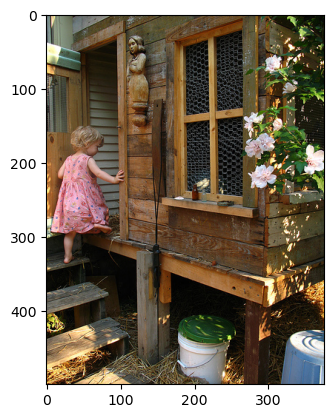

Greedy Search: man in a red shirt is sitting on a bench in front of a fountain
Beam Search, K = 3: man is sitting on a wooden bench next to a tree
Beam Search, K = 5: man is sitting on a wooden bench next to a tree
Beam Search, K = 7: woman is sitting on a bench next to a building
Beam Search, K = 10: man is sitting on a park bench reading a newspaper


In [10]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final



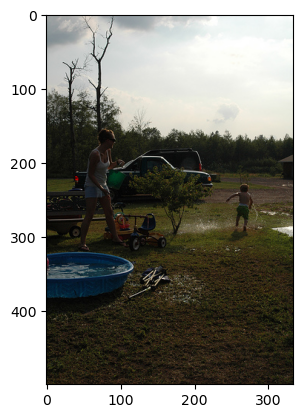

Greedy Search: children are playing in a water fountain
Beam Search, K = 3: people are sitting on bleachers in front of a pool
Beam Search, K = 5: children are playing in a water fountain
Beam Search, K = 7: children are playing in a water fountain
Beam Search, K = 10: group of people sit on bleachers waving fountains


In [15]:
pic = '974924582_10bed89b8d.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

print(encoding_test)